# Jump 2 Digital 💻
## Data Challenge - Akadelivers

By Juan Sirai

![](https://simondecirene.cl/simondecirene_webtres/wp-content/uploads/2020/05/Delivery_1920x700.png)


### Summary
**Akadelivers** es una empresa de reparto a domicilio especializada en la entrega de paquetes en menos de 1 hora, lo que se denomina (Q-commerce = Quick commerce) Esta empresa tiene una aplicación móvil con la que sus usuarios pueden elegir entre un catálogo de productos de tiendas locales de su ciudad y que les sean entregados en menos de 10 minutos a la dirección que deseen. Cuando un usuario pide un pedido a través de Akadelivers se le cobra directamente el coste del producto + gastos de servicio + gastos de envío. Una vez el usuario ha pagado un producto, el repartidor que se encuentre más próximo a la tienda que tiene el producto se acerca a esta, paga el producto, lo recoge y lo lleva a la dirección que el usuario ha elegido. Akadelivers se lo llevara a la dirección indicada.

### Dataset


| Feature | Meaning |
| --- | --- | 
| order_id | Número de identificación del pedido |
| local_time | Hora local a la que se realiza el pedidon |
| country_code | Código del pais en el que se realiza el pedido |
| store_address |Número de tienda en a la que se realiza el pedido |
| payment_status| Estado del pedido |
| n_of_products | Número de productos que se han comprado en ese pedido |
| products_total | Cantidad en Euros que el usuario ha comprado en la app |
| purchase_total_price | Costo total incluyendo envío + servicio |
| final_status | Estado final del pedido, este puede ser si se ha entregado o si se ha cancelado |


### Objetivos

* 1) ¿Cuáles son los 3 paises en los que más pedidos se realizan?
* 2) ¿Cuáles son las horas en las que se realizan más pedidos en España?
* 3) ¿Cuál es el precio medio por pedido en la tienda con ID 12513?
* 4) Teniendo en cuenta los picos de demanda en España, si los repartidores trabajan en turnos de 8horas.
     Turno 1 (00:00-08:00)
     Turno 2 (08:00-16:00)
     Turno 3 (16:00-00:00)
     Qué porcentaje de repartidores pondrías por cada turno para que sean capaces de hacer frente a los picos de demanda. (ej: Turno 1 el 30%, Turno 2 el 10% y Turno 3 el 60%).

* 5) Realiza un modelo predictivo de machine learning a partir del dataset 'train.csv' en el cual a partir de las variables predictoras que se entregan en el dataset 'test_X' se pueda predecir si el pedido se cancelará o no. Siendo:
**   0 = CanceledStatus
**   1 = DeliveredStatus
---------------------------------------------------------------------

## Tabla de contenidos

* [Analisis Preliminar](#Preliminar)
* [1) ¿Cuáles son los 3 paises en los que más pedidos se realizan?](#target_1)
* [2) ¿Cuáles son las horas en las que se realizan más pedidos en España?](#target_2)
* [3) ¿Cuál es el precio medio por pedido en la tienda con ID 12513?](#target_3)
* [4) Asignación de repartidores por turno](#target_4)
* [5) Modelo predictivo](#target_5)

## Librerías a utilizar <a class="anchor" id="Preliminar"></a>

In [144]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import descartes
import matplotlib.gridspec as gridspec
import mapclassify
%config InlineBackend.figure_format = 'retina'
from sklearn.model_selection import train_test_split
sns.set(style="ticks", context="talk")
plt.style.use("fivethirtyeight")

## Dataset y análisis preliminar

In [145]:
df = pd.read_csv('train.csv')

In [146]:
## visualizamos los primeros registros de nuestro dataset
display(df.head(2), df.shape)

,order_id,local_time,country_code,store_address,payment_status,n_of_products,products_total,purchase_total_price,final_status
0,33446280.0,14:11:09,AR,55379.0,PAID,2.0,11.88,11.88,DeliveredStatus
1,33107339.0,11:47:41,GT,23487.0,PAID,2.0,5.20,5.44,DeliveredStatus


(54360, 9)

In [147]:
## imprimimos por pantalla el % de valores nulos
display(df.isnull().sum()/df.shape[0] * 100, df.shape)

order_id                0.055188
local_time              0.055188
country_code            0.055188
store_address           0.055188
payment_status          0.055188
n_of_products           0.055188
products_total          0.055188
purchase_total_price    0.055188
final_status            0.055188
dtype: float64

(54360, 9)

In [148]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
order_id,54330.0,3.278267e+07,445940.244923,31503775.0,32400066.75,32781587.50,33183798.00,33560846.00
store_address,54330.0,4.160938e+04,21903.267141,190.0,21369.00,45993.50,62004.00,75236.00
n_of_products,54330.0,2.815792e+00,2.430936,1.0,1.00,2.00,3.00,39.00
products_total,54330.0,9.838136e+00,9.260352,0.0,4.13,7.13,12.77,221.48
purchase_total_price,54330.0,1.071285e+01,10.778379,0.0,4.34,7.99,14.18,265.76


--------------------------------------------
💡 **Data hint** : Como podemos observar, nuestro dataset posee muy pocos valores nulos, y posee dimensiones de 54360 filas por 9 columnas. Al parecer, tenemos 30 registros en null, que eliminaremos del dataset ya que es un porcentaje muy bajo del total de registros.

Como pequeñas transformaciones, convertiremos el **local_time** a datetime y extraeremos las principales features de fecha

Para ahorrar pasos, vamos a definir una función que reciba como input nuestro dataset, y nos devuelva el dataset con la columna local_time en datetime, y además features adicionales de anio, mes, dia, hora.

```python
def convert_to_time(x):
    x['local_time'] = pd.to_datetime(df['local_time'], dayfirst=True)
    x['year'] = x['local_time'].dt.year
    x['month'] = x['local_time'].dt.month
    x['day'] = x['local_time'].dt.day
    x['day_name'] = x['local_time'].dt.day_name()
    x['hour'] = x['local_time'].dt.hour
    x = x.dropna(axis = 0)
    return x
```

------------------------------------

In [149]:
def convert_to_time(x):
    x['local_time'] = pd.to_datetime(df['local_time'], dayfirst=True)
    x['year'] = x['local_time'].dt.year
    x['month'] = x['local_time'].dt.month
    x['day'] = x['local_time'].dt.day
    x['day_name'] = x['local_time'].dt.day_name()
    x['hour'] = x['local_time'].dt.hour
    x = x.dropna(axis=0, how = 'all')
    
    return x

In [150]:
df = convert_to_time(df)

Como pudimos ver en la linea anterior, tenemos ya nuestro dataset pre-procesado, con algunas columnas adicionales relacionadas al tiempo.
Nos tomaremos unos instantes para analizar los valores de las columnas categóricas, ya que con 
```python
describe().transpose()
```
solamente obtuvimos información estadística de features numéricas.

In [151]:
countries = len(df.country_code.unique())
stores = len(df.store_address.unique())
final_status =len(df.final_status.unique())
payment_status =len(df.payment_status.unique())

diccionario = {'countries':countries,'stores':stores, 'final_status':final_status,'payment_status':payment_status}
pd.DataFrame(list(diccionario.items()),columns = ['feature','valores_unicos'])

,feature,valores_unicos
0,countries,23
1,stores,5627
2,final_status,2
3,payment_status,3


Vamos a mostrar en pantalla los valores que pueden tomar el status final y el payment_status

In [152]:
display(df.final_status.unique(),df.payment_status.unique())

array(['DeliveredStatus', 'CanceledStatus'], dtype=object)

array(['PAID', 'NOT_PAID', 'DELAYED'], dtype=object)

Finalmente, veremos los distintos valores de fechas que tenemos:

In [153]:
display(df.day_name.unique(),df.month.unique(), df.day.unique(), df.hour.unique())

array(['Monday'], dtype=object)

array([11.])

array([22.])

array([14., 11., 20., 21., 22., 12., 17., 19., 15., 18., 10., 13., 16.,
        3.,  9.,  8., 23.,  0.,  1.,  7.,  2.,  4.,  6.,  5.])

--------------------------------------------
💡 **Data hint** : los registros corresponden todos al mismo día, variando unicamente la hora. Es por eso que para las futuras tareas y el entrenamiento del modelo, nos manejaremos solamente con dicha feature.

--------------------------------------------

## 🎯 Target 1: <a class="anchor" id="target_1"></a>
### ¿Cuáles son los 3 paises en los que más pedidos se realizan?

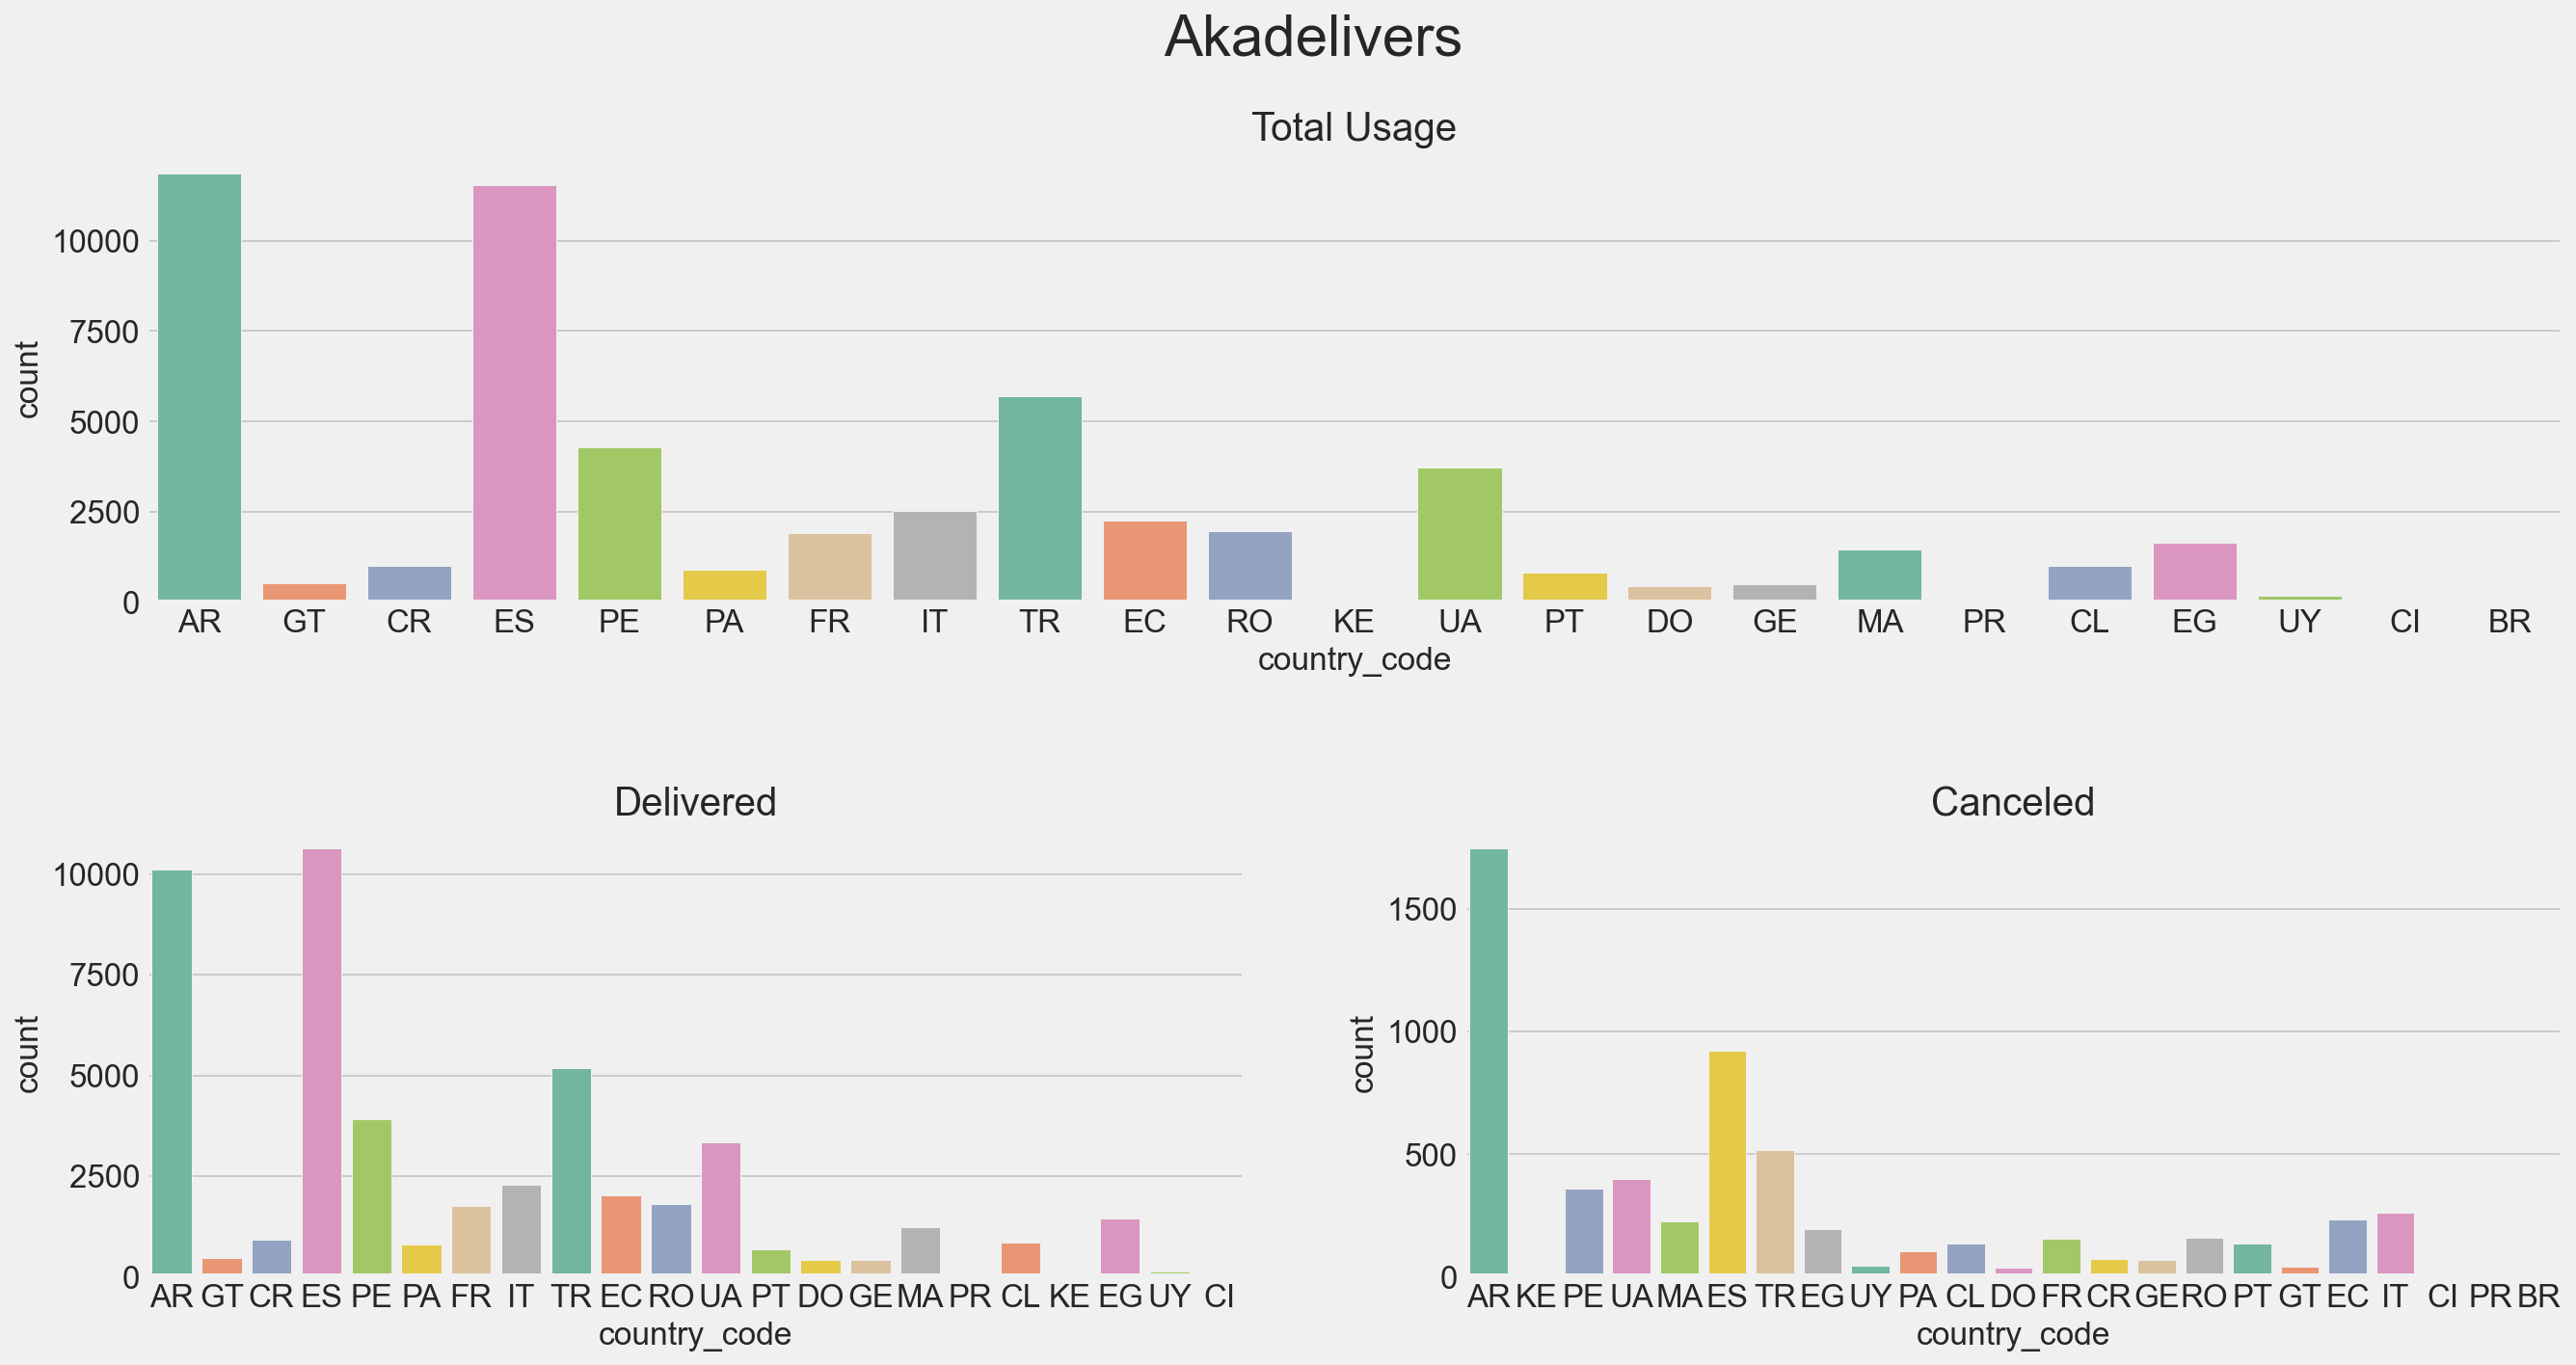

In [154]:
#for rect in ax.patches:
#    ax.text (rect.get_x() + rect.get_width()  / 2,rect.get_height()+ 0.75,
#             rect.get_height(),horizontalalignment='center', fontsize = 10)
fig = plt.figure(1)
plt.suptitle('Akadelivers',fontsize=30)
# set up subplot grid
gridspec.GridSpec(2,2)

# large subplot
plt.subplot2grid((2,2), (0,0), colspan=2, rowspan=1)
plt.locator_params(axis='x', nbins=5)
plt.locator_params(axis='y', nbins=5)
plt.title('Total Usage')
plt.xlabel('Country')
plt.ylabel('Orders')
ax =sns.countplot(x = df.country_code, palette='Set2')

# small subplot 1
plt.subplot2grid((2,2), (1,0),colspan=1)
plt.locator_params(axis='x', nbins=5)
plt.locator_params(axis='y', nbins=5)
plt.title('Delivered')
plt.xlabel('Country')
plt.ylabel('Orders')
ax =sns.countplot(x = df.loc[df['final_status']=='DeliveredStatus'].country_code, palette='Set2')

# small subplot 2
plt.subplot2grid((2,2), (1,1),colspan=1)
plt.locator_params(axis='x', nbins=5)
plt.locator_params(axis='y', nbins=5)
plt.title('Canceled')
plt.xlabel('Country')
plt.ylabel('Orders')
ax =sns.countplot(x = df.loc[df['final_status']=='CanceledStatus'].country_code, palette='Set2')


# fit subplots and save fig

fig.set_size_inches(w=20,h=10)
plt.subplots_adjust(hspace=.5)
plt.show()

Tal como podemos apreciar, Argentina, España y Turquía son los 3 países en los que más envíos se realizan, con las siguientes observaciones:
* Si analizamos uso total de la aplicacion, Argentina es quien más pedidos registra.
* Análogamente, si analizamos cancelaciones, la mayor cantidad (total) se da en el país latinoamericano
* Como resultado, si analizamos luego ordenes entregadas, España queda como país top one.

--------------------------------------------
💡 **Data hint** : ¿Cómo podemos ver esta información en un mapa?

Para abordar una forma distinta de visualizar los datos, utilizaré la librería geopandas para plotear en un mapa la cantidad de pedidos por país.
Utilizaremos para eso el dataset word de geopandas, que nos provee de los polígonos asociados a cada país para poder graficarlos en un mapa, y a su vez necesitaremos asociar el codigo de países de nuestro dataset, con su equivalencia ISO a fin de mergear ambas tablas en un único dataset auxiliar

--------------------------------------------

In [155]:
#descarcamos el dataset de paises
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres')) 
#generamos tabla auxiliar de medidas agrupadas, para sacar totalespor país
aux = pd.DataFrame(df.loc[df['final_status']=='DeliveredStatus'].pivot_table(index='country_code',
                 values=['order_id','n_of_products', 'products_total','purchase_total_price'], 
                 aggfunc={'order_id':'count','n_of_products':'sum',
                         'products_total':'sum','purchase_total_price':'sum'}))
#feature adicional que podría indicarnos el sobrecosto de envío
aux['dif'] = (aux['purchase_total_price']- aux['products_total'])/aux['order_id']
#reseteamos el index
aux = aux.reset_index()
#generamos un diccionario con las equivalencias ISO
di = {'AR': 'ARG', 'BR':'BRA','CI':'CIV','CL':'CHL','CR':'CRI','DO':'DOM',
       'EC':'ECU','EG':'EGY', 'ES':'ESP','FR':'FRA','GE':'GEO', 'GT':'GTM',
        'IT':'ITA','KE':'KEN','MA':'MAR','PA':'PAN','PE':'PER','PR':'PRI','PT':'PRT',
        'RO':'ROM','TR':'TUR','UA':'USA','UY':'URY'}
#reemplazamos en la tabla
aux = aux.replace({"country_code": di})
#eralizamos el merge
aux2=pd.merge(world,aux,how='left',left_on='iso_a3',right_on='country_code')
#llenamos NA con 0
aux2['products_total']= aux2['products_total'].fillna(0)
aux2['order_id']= aux2['order_id'].fillna(0)

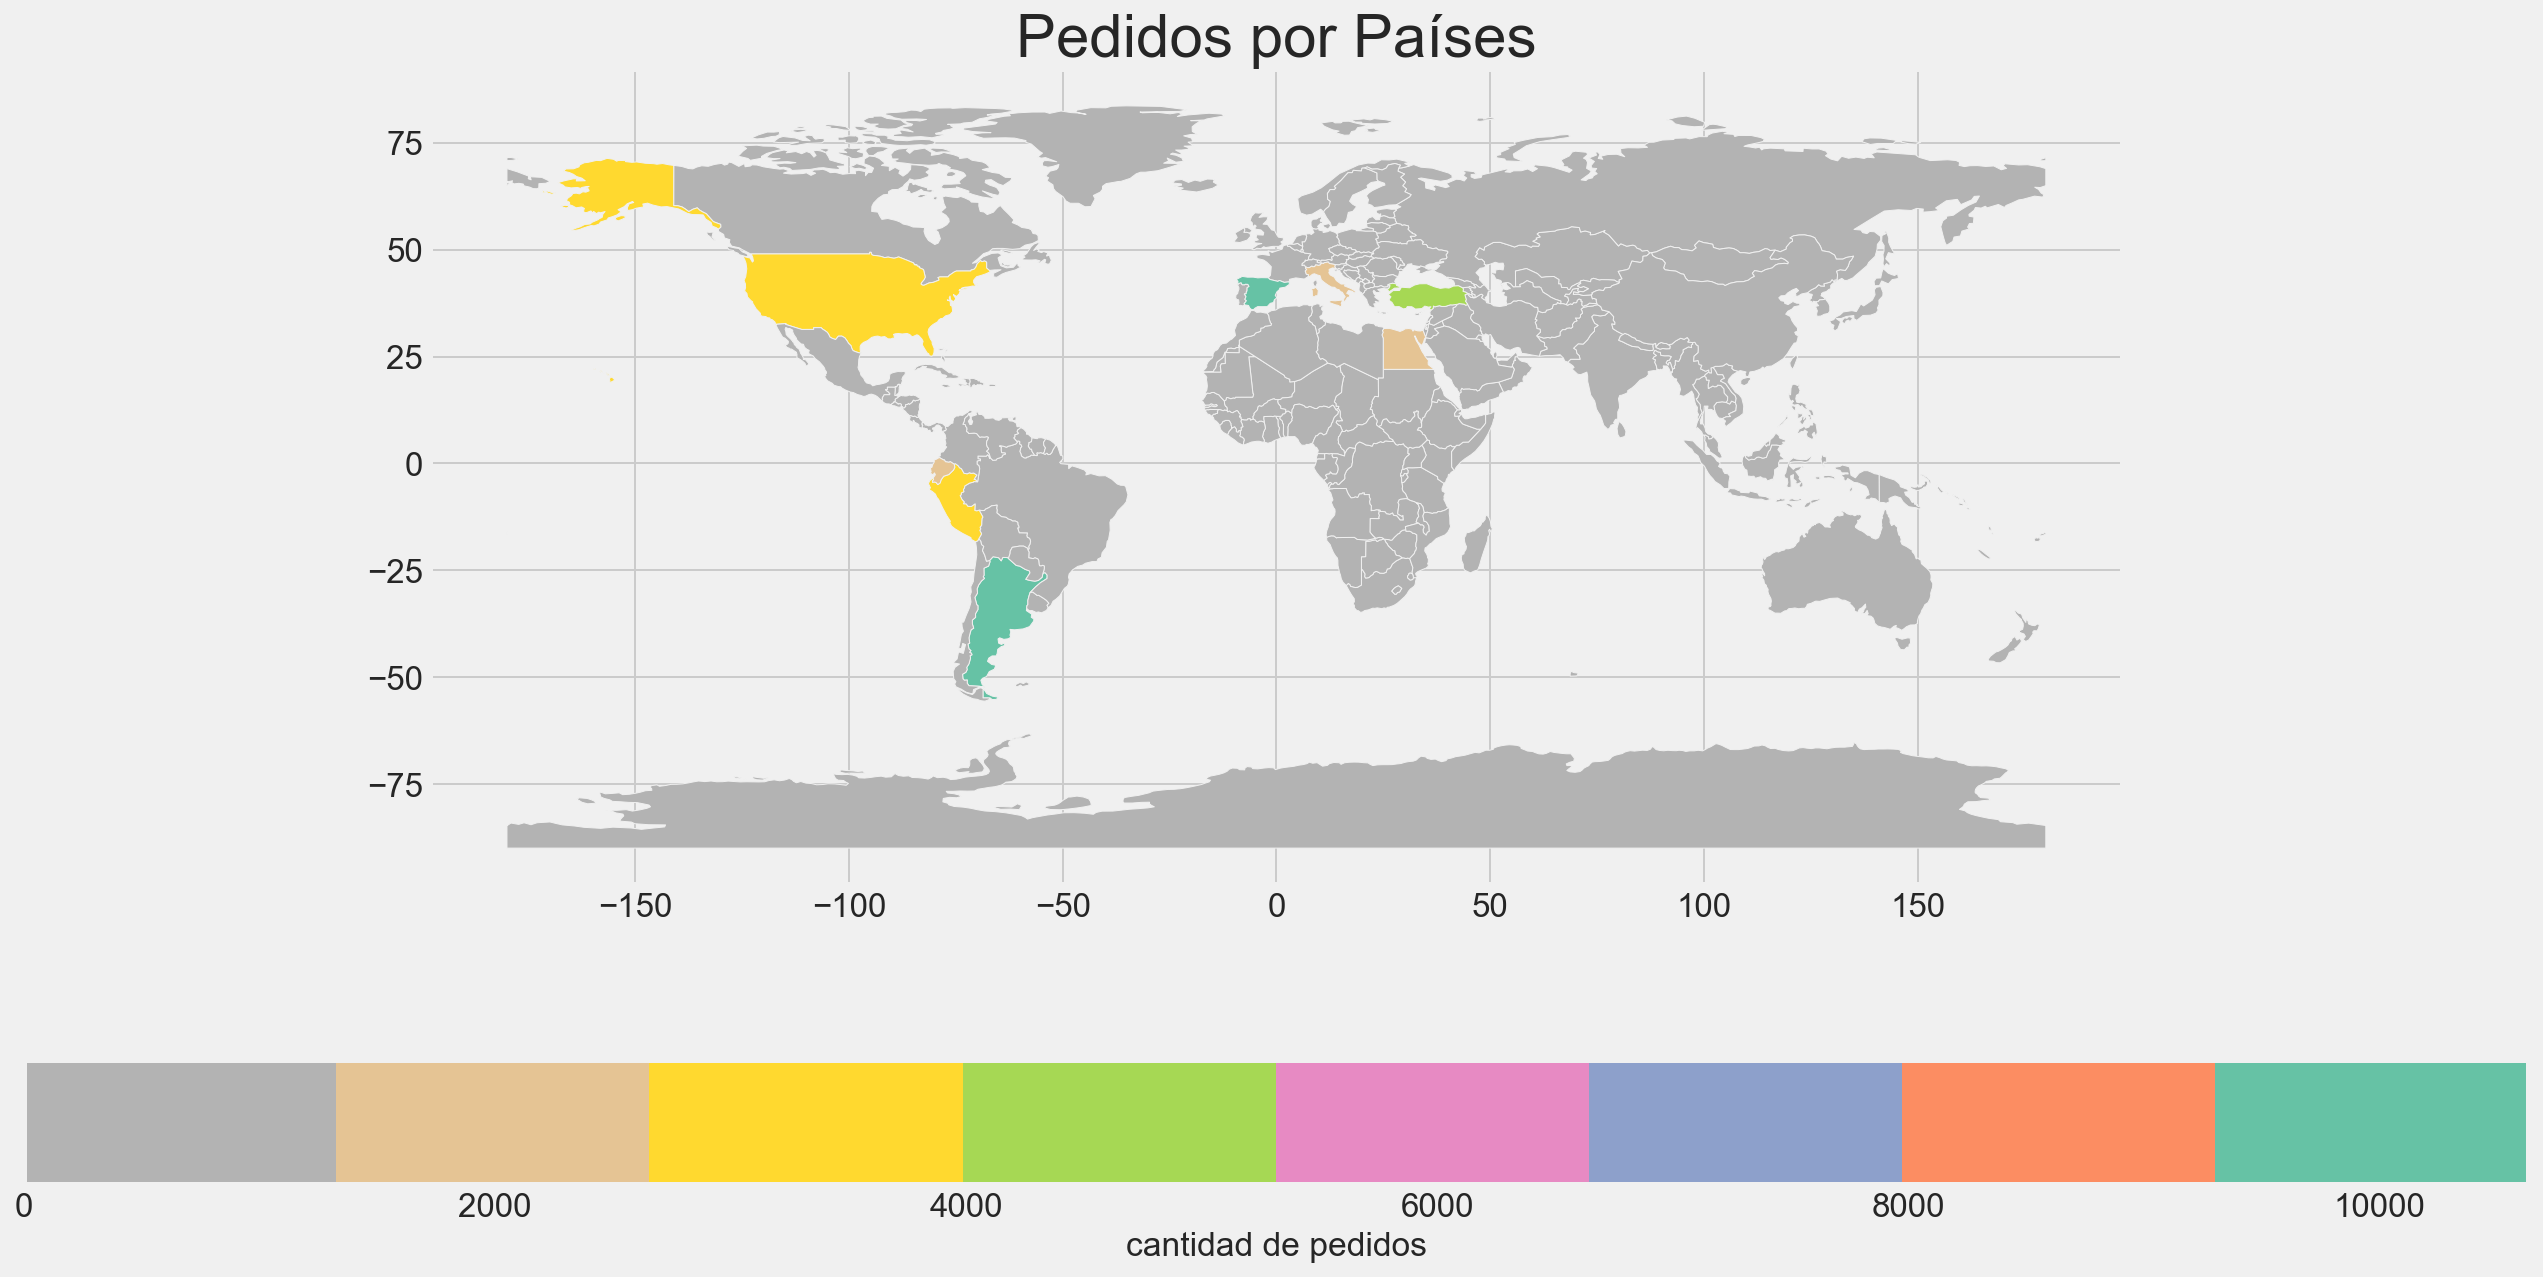

In [156]:
#ploteamos
fig, ax = plt.subplots(1, 1, figsize=(20,10))

aux2.plot(column='order_id',ax=ax, legend=True,  legend_kwds={'label': "cantidad de pedidos",
                        'orientation': "horizontal"},cmap='Set2_r')
plt.title('Pedidos por Países', size=30);

## 🎯 Target 2: <a class="anchor" id="target_2"></a>
### ¿Cuáles son las horas en que se realizan más pedidos en España?

In [157]:
## Nos quedaremos con un recorte de nuestro dataset original, para trabajar solo con España
df_es = df.loc[df['country_code']=="ES"]

Text(0.5, 1.0, 'Cantidad de Pedidos según hora - España')

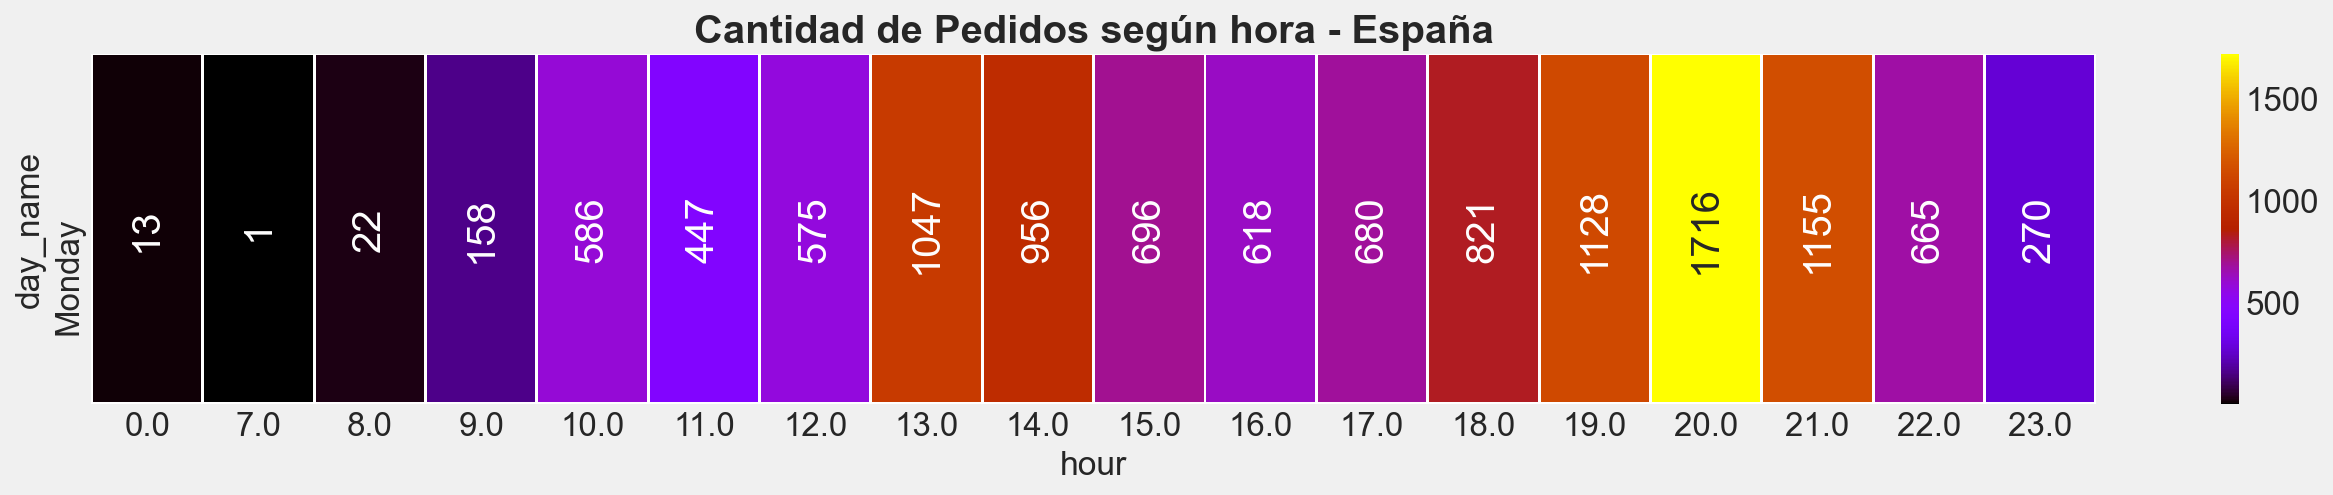

In [158]:
plt.figure(figsize=(20,3))

sns.heatmap(df_es.pivot_table(values = 'order_id', index=df_es['day_name'],
                              columns=df['hour'], aggfunc={'order_id':'count'}), linewidth=1,cmap='gnuplot', 
                               annot=True,fmt='.0f', annot_kws={'rotation': 90, 'size':20})
plt.title('Cantidad de Pedidos según hora - España',size=20, weight='bold')

A partir del análisis de la cantidad de pedidos por hora, podemos ver que tenemos dos picos:
* Entre las 13 y 14 hs
* Entre las 19 y 21 hs
* 20hs es el máximo
De allí que podríamos formular la hipótesis de que, en España, el servicio está muy asociado también a lo que es entrega de comida (ya que coincide con los momentos de almuerzo y cena)

--------------------------------------------
💡 **Data hint** : 

¿Qué sucede en el resto del mundo?

De manera muy rápida, y a través de una tabla pivot similar pero construida a partir de dataset original, realizaremos un análisis de consumo por hora en todos los países en los cuales la empresa tiene prestación de servicio.

--------------------------------------------

In [159]:
df2 = df.pivot_table(values = 'order_id',index=df['country_code'],columns=df['hour'], aggfunc={'order_id':'count'})

Text(0.5, 1.0, 'Lunch Time!')

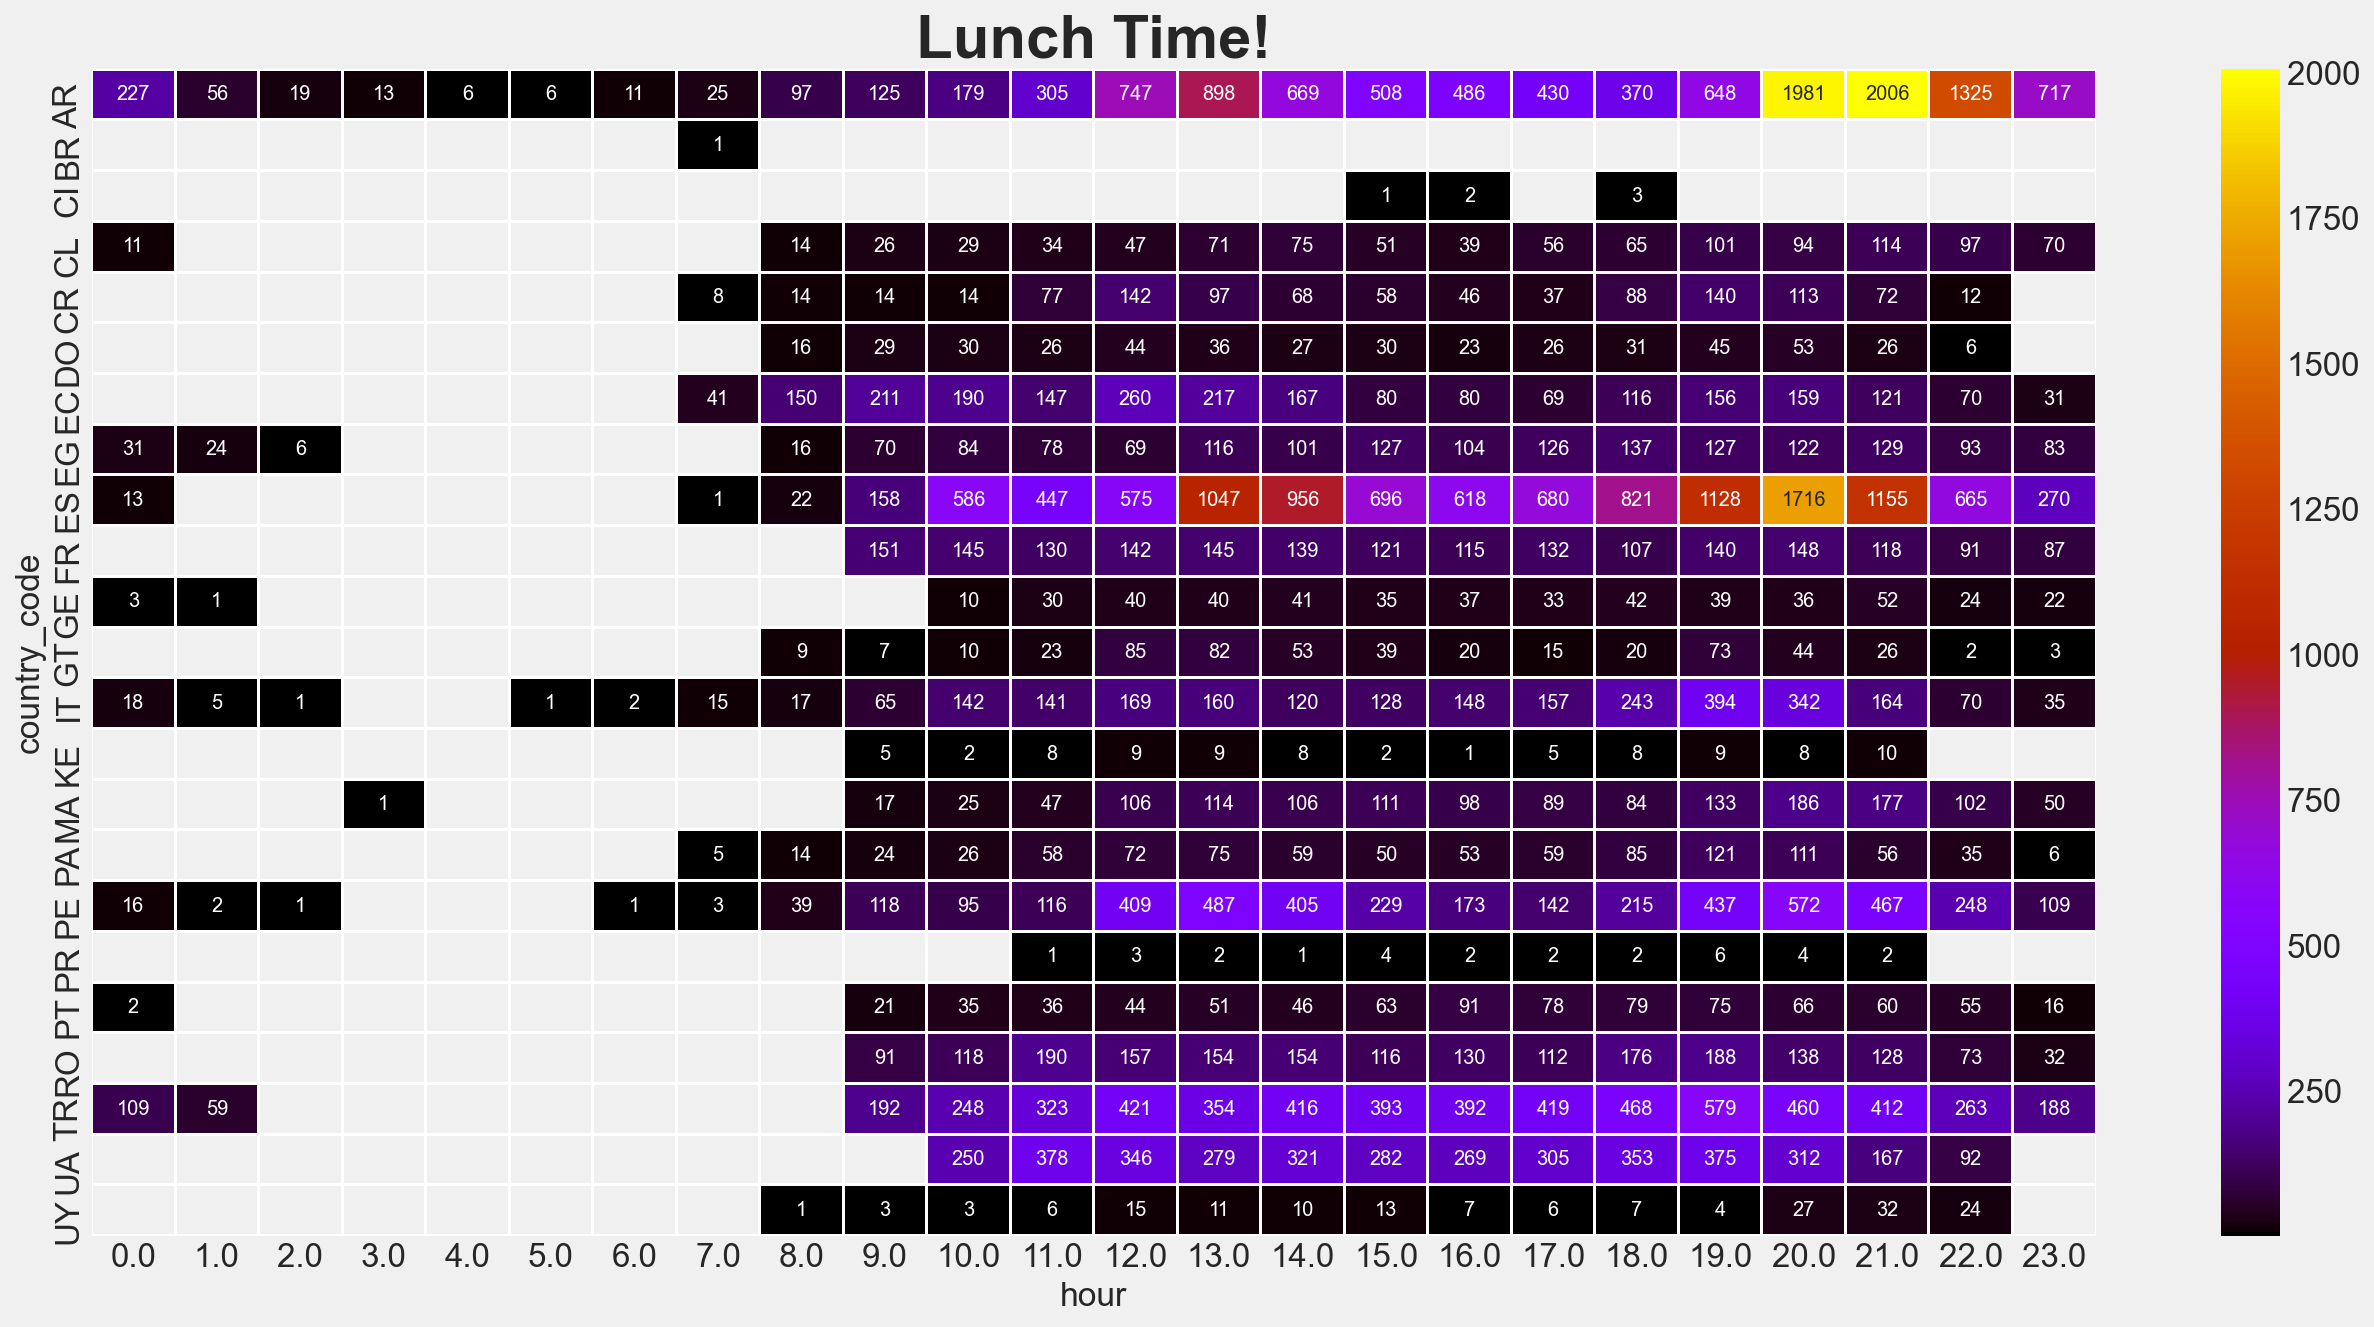

In [160]:
plt.figure(figsize=(20, 10))
sns.heatmap(df2,cmap='gnuplot', linewidths=1,annot=True,fmt='.0f', annot_kws={ 'size':10})
plt.title("Lunch Time!", size=30, weight='bold')

Algunas conclusiones rápidas de la imagen anterior:
* Tanto en Argentina como en España tenemos dos picos de consumo, al mediodía y a la noche (este último es el máximo), que coincide con los horarios de almuerzo y cena.
* En Argentina el pico nocturno se encuentra más tarde que en España, lo que podría deberse a pautas culturales (la hora de la cena no es igual en todos los países, por usos y costumbres).
* Argentina e Italia son los únicos países que mantienen actividad casi 24 hs

## 🎯 Target 3: <a class="anchor" id="target_3"></a>
### ¿Cuál es el precio medio por pedido en la tienda con ID 12513?

Vamos a resolver este punto con una pequeña función, que dado el dataset y un numero de tienda como parámetro, nos devuelva:
* Cantidad de ordenes de esa tienda
* Precio promedio del item: entendida como el monto total de pedidos dividido la cantidad total de items. Mostraría en promedio qué tan caros son los items que compran en la tienda.
* Precio promedio por pedido: entendida como monto total de pedidos dividido la cantidad total de pedidos. Mostraría en promedio cuánto gastan en esa tienda.

```python
def getStoreRatios(data, tienda):
    store_subset = data.loc[data['store_address']==tienda] # me quedo con el subset de la tienda
    # Calculo ratios 
    tot_prod = store_subset.n_of_products.sum() 
    purchase_price = store_subset.products_total.sum()
    item_promedio = purchase_price // tot_prod
    orders = store_subset.order_id.count()
    purchase_promedio = purchase_price //orders
    #concateno los ratios anteriores en un string
    string = ".." 
    #devuelvo el string
    return string
```

In [161]:
def getStoreRatios(data, tienda):
    store_subset = data.loc[data['store_address']==tienda]
    tot_prod = store_subset.n_of_products.sum()
    purchase_price = store_subset.products_total.sum()
    item_promedio = purchase_price // tot_prod
    orders = store_subset.order_id.count()
    purchase_promedio = purchase_price //orders
    string = f"La tienda {tienda} tuvo {orders} ordenes de pedido, con un precio promedio de item de {item_promedio} y un promedio gastado de {purchase_promedio} sin adicionales por envío😀"
    return string

In [162]:
getStoreRatios(df, 12513)

'La tienda 12513 tuvo 245 ordenes de pedido, con un precio promedio de item de 6.0 y un promedio gastado de 17.0 sin adicionales por envío😀'

## 🎯 Target 4: <a class="anchor" id="target_4"></a>
### 
4) Teniendo en cuenta los picos de demanda en España, si los repartidores trabajan en turnos de 8horas.
     Turno 1 (00:00-08:00)
     Turno 2 (08:00-16:00)
     Turno 3 (16:00-00:00)
     Qué porcentaje de repartidores pondrías por cada turno para que sean capaces de hacer frente a los picos de demanda. (ej: Turno 1 el 30%, Turno 2 el 10% y Turno 3 el 60%).

In [163]:
def generate_turn(hour):
    if hour <8:
        return "Turno 1"
    elif hour <16:
        return "Turno 2"
    else:
        return "Turno 3"

df['turno'] = df.hour.apply(lambda x:generate_turn(x))

In [164]:
mask = (df['final_status']=="DeliveredStatus") & (df['country_code']=="ES")
df2 = df.loc[mask]

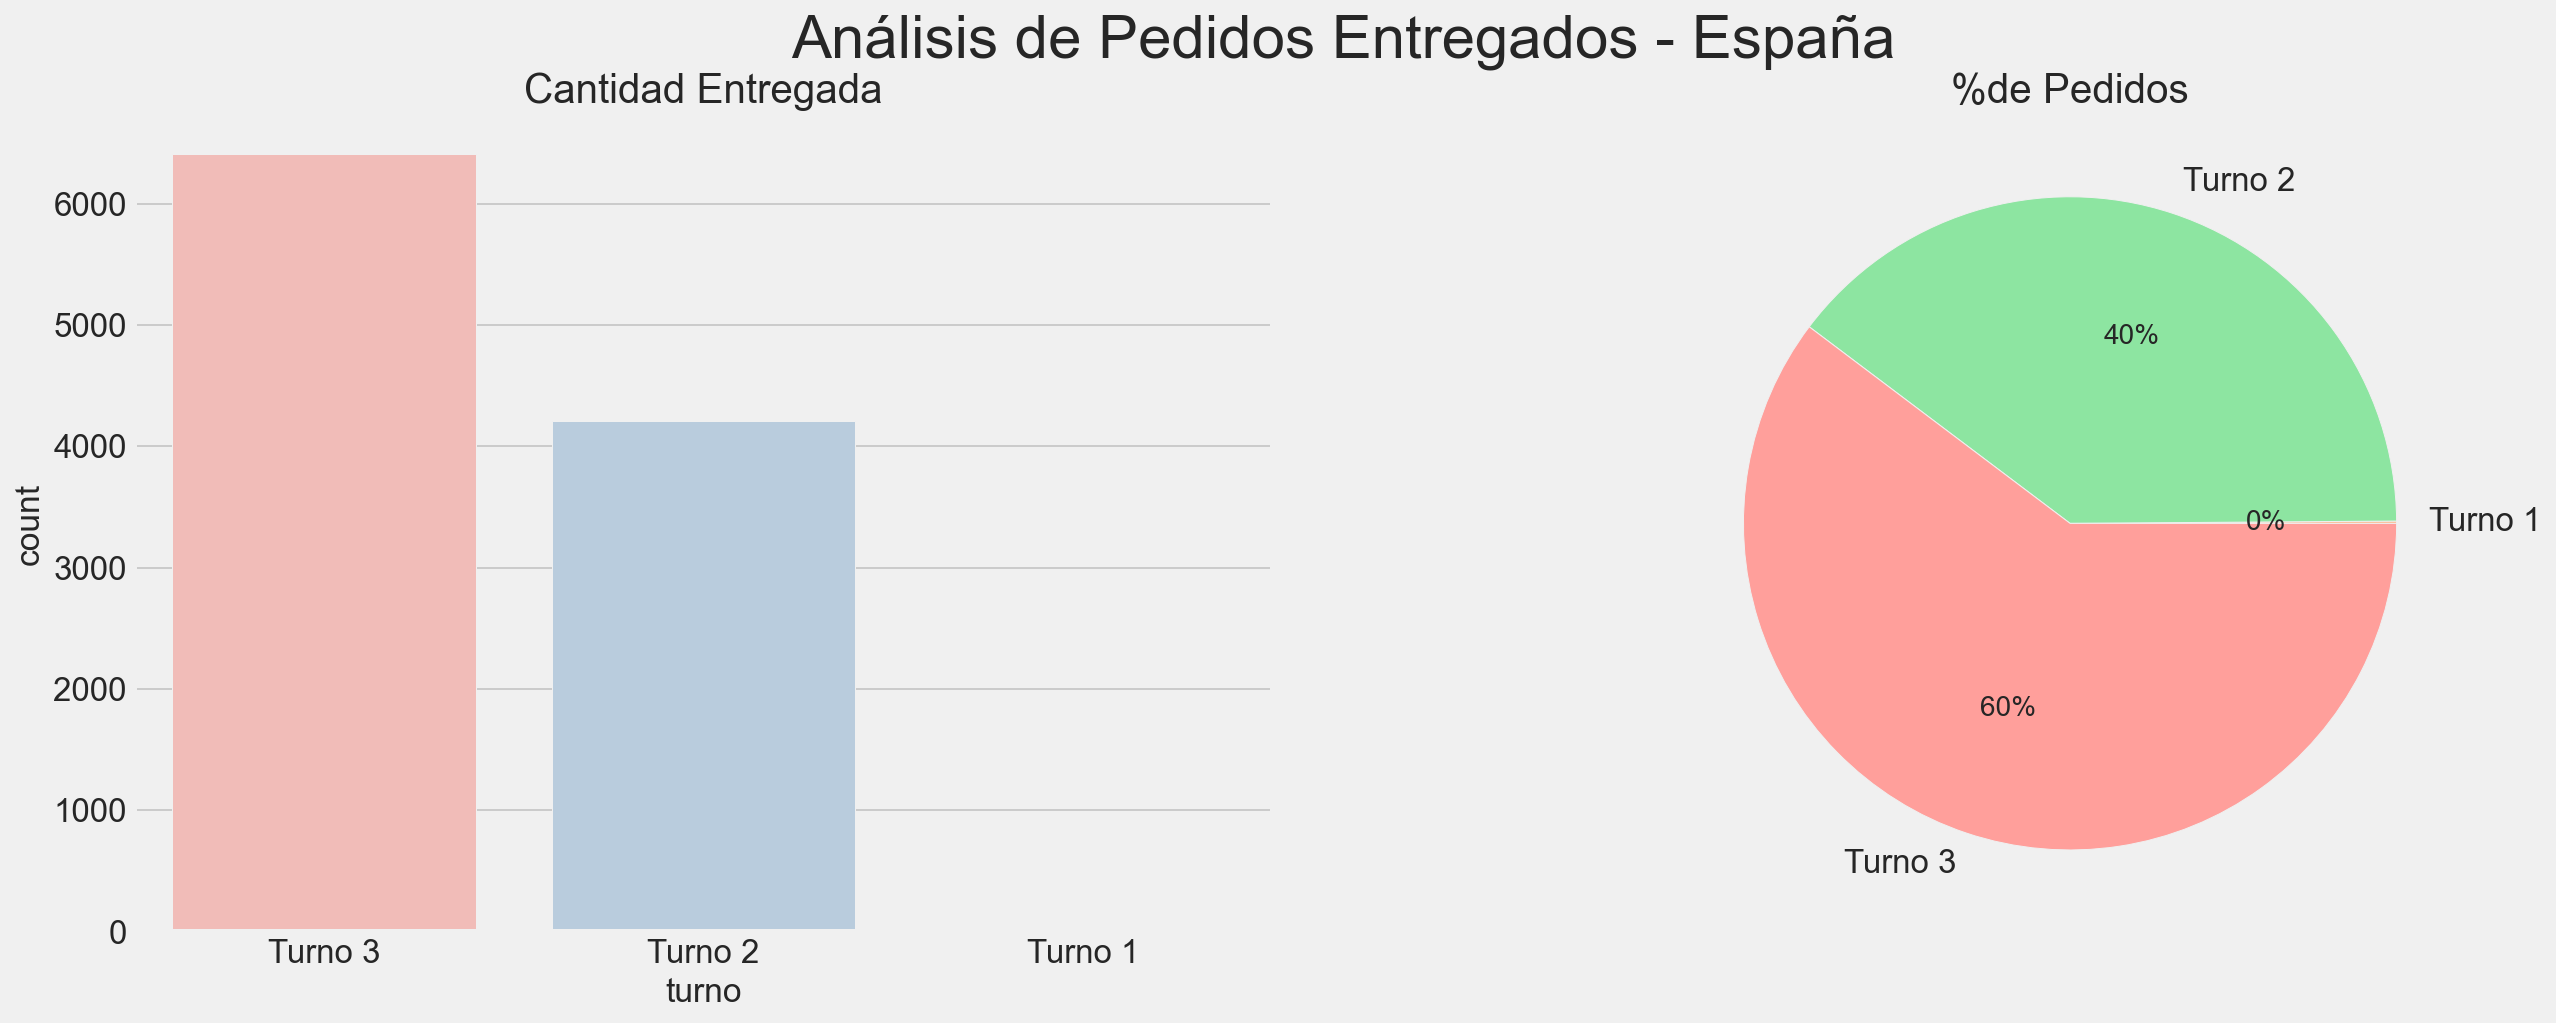

In [165]:
fig = plt.figure(1)
plt.suptitle('Análisis de Pedidos Entregados - España',fontsize=30,x = .5)
# set up subplot grid
gridspec.GridSpec(1,2)

plt.subplot2grid((1,2), (0,0), colspan=1, rowspan=1)
plt.title('Cantidad Entregada')
plt.xlabel('Turno')
plt.ylabel('Pedidos')
sns.countplot(x=df2.turno,palette="Pastel1")


values = []
labels = ["Turno 1", "Turno 2", "Turno 3"]
for i in range(3):
    values.append((df2.groupby('turno')["order_id"].count()/df2.shape[0])[i])

colors = sns.color_palette('pastel')[1:5]
plt.subplot2grid((1,2), (0,1), colspan=1, rowspan=1)
plt.title('%de Pedidos')
plt.pie(values, labels = labels, colors = colors, autopct='%.0f%%')



fig.set_size_inches(w=20,h=7)
plt.subplots_adjust(hspace=.1)
plt.show()

Tal como observamos en el gráfico, la mayor cantidad de pedidos se concentra en el turno 3 y 2. De acuerdo a ello, la distribución de repartidores propuesta es:
* Turno 3: 60% de repartidores (Pico de demanda)
* Turno 2: 39% de repartidores (Si bien el % de pedidos en este turno es 40%, estoy dispuesto a sacrificar rendimiento a fin de poder dejar una guardia mínima en el turno noche)
* Turno 1: 1% (Guardia mínima a fin de cubrir los pedidos nocturnos)

## 🎯 Target 5: <a class="anchor" id="target_5"></a>

* 5) Realiza un modelo predictivo de machine learning a partir del dataset 'train.csv' en el cual a partir de las variables predictoras que se entregan en el dataset 'test_X' se pueda predecir si el pedido se cancelará o no. Siendo:
**   0 = CanceledStatus
**   1 = DeliveredStatus

Para comenzar este último punto, vamos a partir desde cero con nuestro dataset original, y realizaremos las modificaciones necesarias para entrenar el modelo.

In [197]:
df_train = pd.read_csv('train.csv')
df_train.shape

(54360, 9)

Reutilizaremos nuestra antigua función "convert_to_time", pero con algunas modificaciones que nos permitan pre procesar todo nuestro dataset de una vez.

In [198]:
def preprocessing(x):
    #extract hour
    x['local_time'] = pd.to_datetime(df['local_time'], dayfirst=True)
    x['hour'] = x['local_time'].dt.hour
    #tagging el target
    x['final_status'] = x.final_status.apply(lambda x: 1 if x=="CanceledStatus" else 0)
    #quitamos los valores nulos que teniamos al inicio
    x.dropna(axis=0, inplace=True)
    return x.head(2)

In [199]:
preprocessing(df_train)

,order_id,local_time,country_code,store_address,payment_status,n_of_products,products_total,purchase_total_price,final_status,hour
0,33446280.0,2021-11-22 14:11:09,AR,55379.0,PAID,2.0,11.88,11.88,0,14.0
1,33107339.0,2021-11-22 11:47:41,GT,23487.0,PAID,2.0,5.20,5.44,0,11.0


In [200]:
df_train.isnull().sum()

order_id                0
local_time              0
country_code            0
store_address           0
payment_status          0
n_of_products           0
products_total          0
purchase_total_price    0
final_status            0
hour                    0
dtype: int64

In [201]:
df_train.final_status.value_counts()

0    48498
1     5832
Name: final_status, dtype: int64

In [202]:
## Eliminamos las columnas que no utilizaremos para el analisis
df_train = df_train.drop(['order_id','local_time','store_address','purchase_total_price', 'country_code'], axis=1)

---------------------------
## Data HINT
En un primer análisis, habíamos entrenado el modelo incluyendo la feature "purchase_total_price". Sin embargo, la misma tenía una relación muy marcada con nuestra variable target (al punto en que cuanto más cercana a cero era el valor de purchase_total_price, casi seguro que el pedido había sido cancelado.
Dado que en el enunciado no teníamos información específica sobre qué representaba dicha variable, y para evitar problemas de filtrado de datos (es decir, enviarle a nuestro modelo señales explícitas de nuestro target), decidimos omitir su consideración.




----------------------------

In [203]:
df_train['hour'] = df_train.hour.astype('int64')

In [204]:
df_train.head(2)

,payment_status,n_of_products,products_total,final_status,hour
0,PAID,2.0,11.88,0,14
1,PAID,2.0,5.20,0,11


### Separamos nuestras features de la variable target

In [205]:
X_model= df_train.drop(['final_status'], axis=1)
y_model= df_train.final_status

### Generacion de variables dummies

In [209]:
X_model = pd.get_dummies(X_model, drop_first=True)

In [210]:
X_model.columns

Index(['n_of_products', 'products_total', 'hour', 'payment_status_NOT_PAID',
       'payment_status_PAID'],
      dtype='object')

### Separamos el dataset en prueba y testeo

In [211]:
X_train, X_test, y_train, y_test = train_test_split(X_model, y_model, test_size=0.30, random_state=42, stratify=y_model)

In [212]:
y_model.value_counts()

0    48498
1     5832
Name: final_status, dtype: int64

In [213]:
display("Train",y_train.value_counts(),"Test",y_test.value_counts())

'Train'

0    33949
1     4082
Name: final_status, dtype: int64

'Test'

0    14549
1     1750
Name: final_status, dtype: int64

In [214]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

In [215]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
cv = StratifiedKFold(n_splits=5, random_state=41, shuffle=True)

In [216]:
#Creamos una funcion para evaluar nuestro modelo
def model_performance(model, name, X, y, cv):
    s = cross_val_score(model, X, y, cv=cv, n_jobs=-1)
    print("Performance of {}:\t{:0.3} ± {:0.3}".format( \
        name, s.mean().round(3), s.std().round(3)))

In [217]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=1)

model_performance(dt,"Tree base", X_train, y_train, cv)

Performance of Tree base:	0.827 ± 0.004


In [218]:
ab = AdaBoostClassifier(base_estimator=dt, n_estimators=500,random_state=1)
model_performance(ab, "AdaBoostClassifier",  X_train, y_train, cv)

Performance of AdaBoostClassifier:	0.841 ± 0.005


In [219]:
gb = GradientBoostingClassifier()
model_performance(gb, "GradientBoostingClassifier", X_train, y_train, cv)

Performance of GradientBoostingClassifier:	0.892 ± 0.001


In [40]:
##GradientBoostingClassifier() con gridSearchCV

from sklearn.model_selection import GridSearchCV

params_gb = {'n_estimators':[500, 1000] , 
             'learning_rate':[0.001, 0.001, 0.1],
            'max_depth' : [1, 2, 3, 4]}

grid_gb = GridSearchCV(gb, param_grid=params_gb, cv=cv, verbose=1, n_jobs=3)


In [41]:
grid_gb.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:  3.6min
[Parallel(n_jobs=3)]: Done 120 out of 120 | elapsed: 10.5min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=41, shuffle=True),
             estimator=GradientBoostingClassifier(), n_jobs=3,
             param_grid={'learning_rate': [0.001, 0.001, 0.1],
                         'max_depth': [1, 2, 3, 4],
                         'n_estimators': [500, 1000]},
             verbose=1)

In [44]:
model_performance(grid_gb.best_estimator_,  "GradientBoostingClassifier + GS", X_train, y_train, cv)

Performance of AdaBoostClassifier + GS:	0.893 ± 0.0


## ROC Curve

In [42]:
from sklearn.metrics import roc_auc_score

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

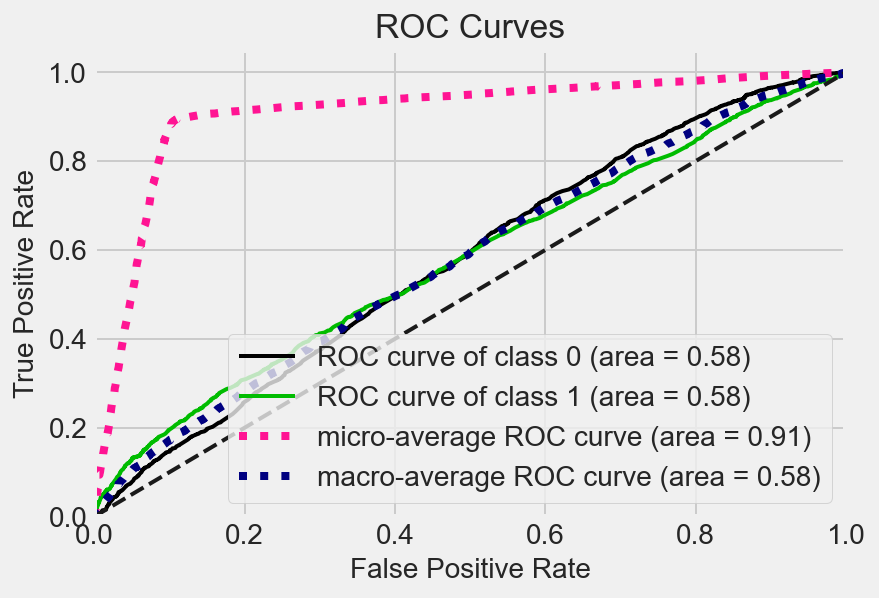

In [43]:
from scikitplot.metrics import plot_roc
plot_roc(y_test,grid_gb.predict_proba(X_test))

In [44]:
xgb_auc = roc_auc_score(y_test,grid_gb.predict(X_test))
print("AUC Value is: ", xgb_auc)

AUC Value is:  0.5003652288326149


### Importancia de features

In [45]:
model = grid_gb.best_estimator_
model

GradientBoostingClassifier(max_depth=1, n_estimators=1000)

In [46]:
importances = model.feature_importances_
importances

array([0.10170773, 0.22913716, 0.5661702 , 0.        , 0.1029849 ])

C:\Users\juans\anaconda3\envs\dhdsblend\lib\site-packages\ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
  if __name__ == '__main__':


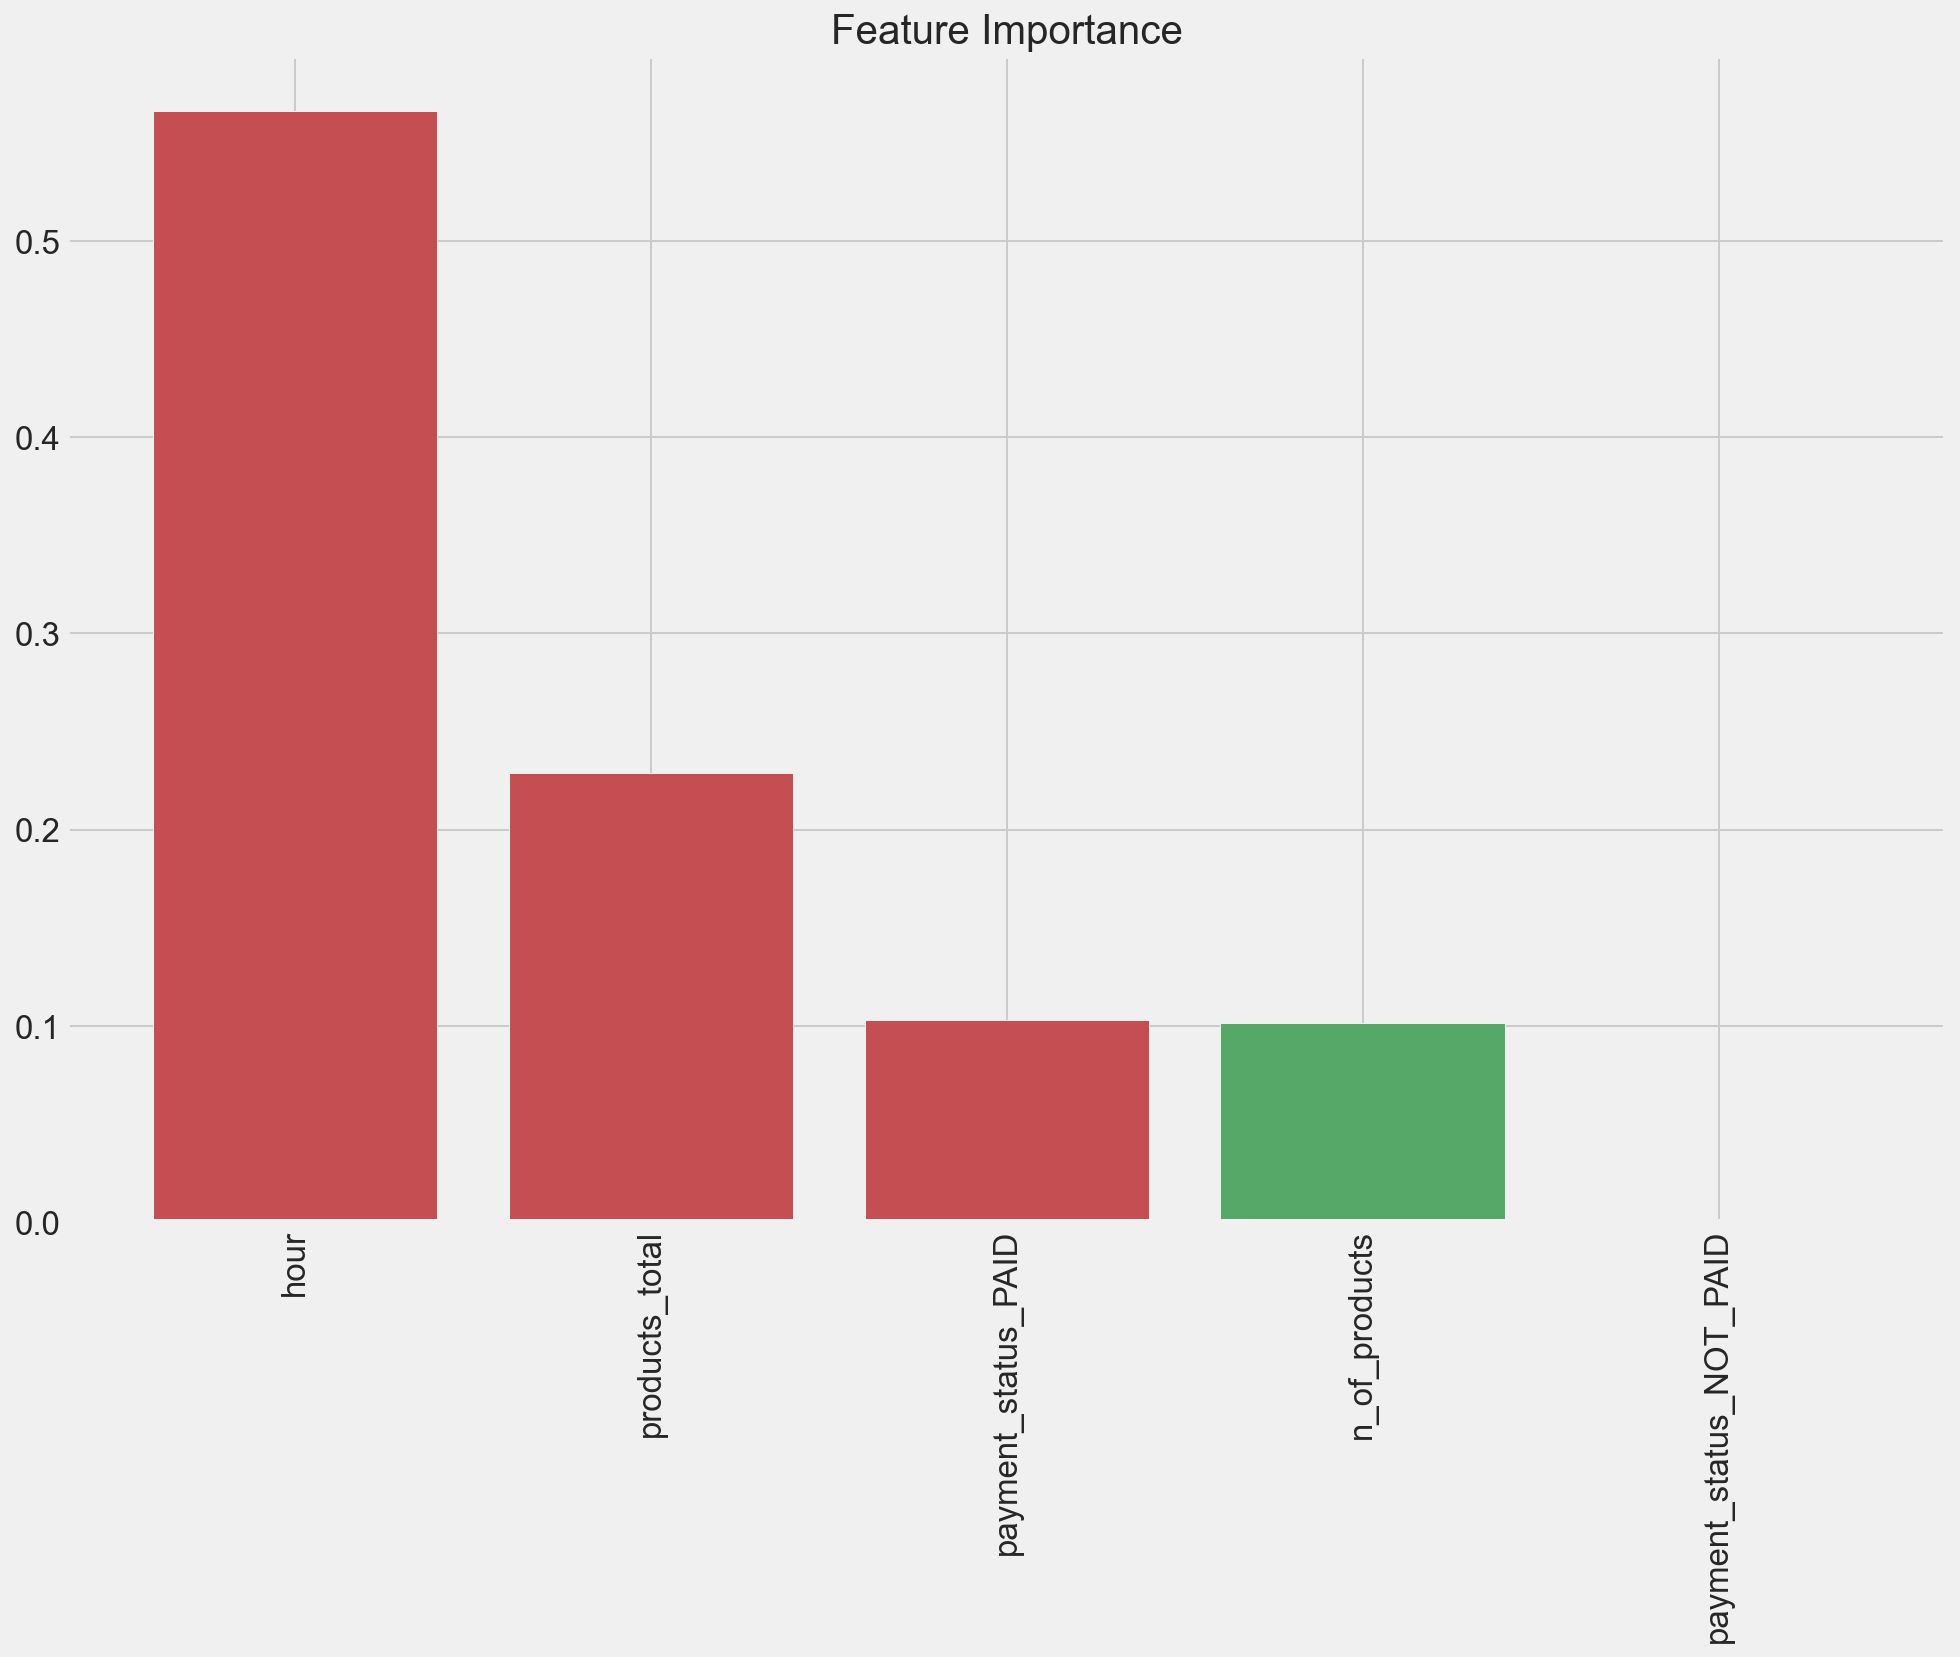

In [47]:
index = np.argsort(importances)[::-1]
names = X_model.columns[index]

plt.figure(figsize=(15,10))

plt.title("Feature Importance")


plt.bar(range(X_model.shape[1]), importances[index],color='rrrggggggggggggggggggggggggggggggggggggggg')

plt.xticks(range(X_model.shape[1]), names, rotation=90)

# Show plot
plt.show()

### Confusion Matrix

In [48]:
modelgb = grid_gb.best_estimator_

In [49]:
y_pred_gb=modelgb.predict(X_test)

Text(0.5, 1.0, 'Confusion Matrix GB Model')

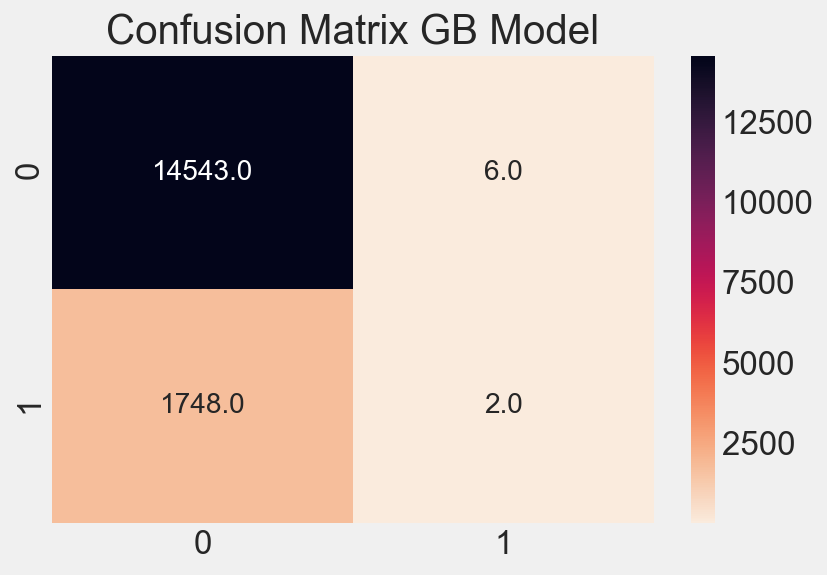

In [56]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred_gb)
sns.heatmap(conf_mat, annot=True, cmap='rocket_r',fmt= '.1f')
plt.title(label='Confusion Matrix GB Model')

## Oversampling

In [57]:
from imblearn.over_sampling import RandomOverSampler

oversampler=RandomOverSampler(sampling_strategy='minority');

X_train_os,y_train_os=oversampler.fit_resample(X_train,y_train);

print('training set:')
print(y_train_os.value_counts())

print('\ntest set:')
print(y_test.value_counts())

training set:
1    33949
0    33949
Name: final_status, dtype: int64

test set:
0    14549
1     1750
Name: final_status, dtype: int64


In [58]:
gb_os = GradientBoostingClassifier()
model_performance(gb_os, "GradientBoostingClassifier", X_train_os, y_train_os, cv)

Performance of GradientBoostingClassifier:	0.58 ± 0.004


In [59]:
params_gb_os = {'n_estimators':[500, 1000] , 
             'learning_rate':[0.001, 0.001, 0.1],
            'max_depth' : [1, 2, 3, 4]}

grid_gb_os = GridSearchCV(gb_os, param_grid=params_gb_os, cv=cv, verbose=1, n_jobs=3)

In [62]:
grid_gb_os.fit(X_train_os, y_train_os)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:  6.9min
[Parallel(n_jobs=3)]: Done 120 out of 120 | elapsed: 19.5min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=41, shuffle=True),
             estimator=GradientBoostingClassifier(), n_jobs=3,
             param_grid={'learning_rate': [0.001, 0.001, 0.1],
                         'max_depth': [1, 2, 3, 4],
                         'n_estimators': [500, 1000]},
             verbose=1)

In [63]:
model_performance(grid_gb_os.best_estimator_, "GradientBoostingClassifier", X_train_os, y_train_os, cv)

Performance of GradientBoostingClassifier:	0.717 ± 0.003


<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

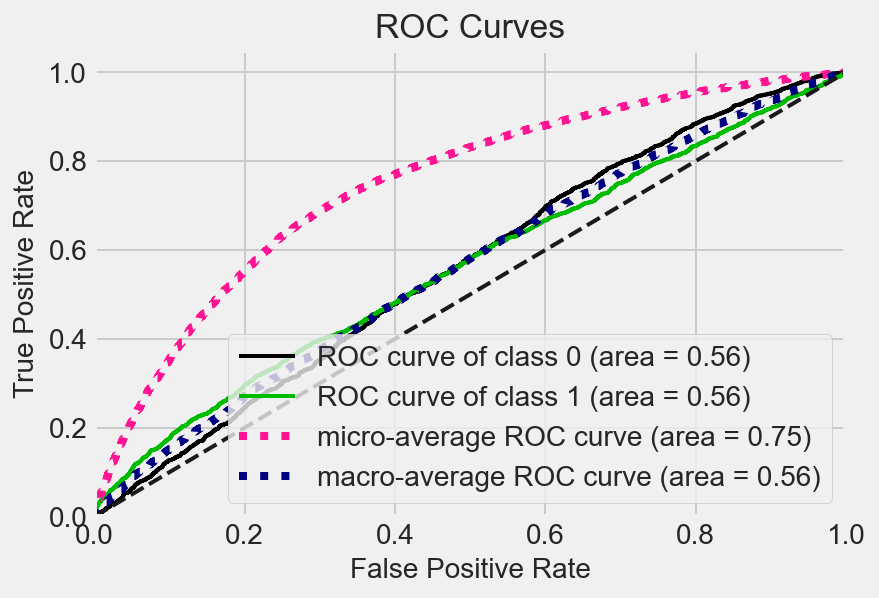

In [220]:
plot_roc(y_test,grid_gb_os.predict_proba(X_test))

In [221]:
model_os = grid_gb_os.best_estimator_
model_os

GradientBoostingClassifier(max_depth=4, n_estimators=1000)

In [222]:
importances_os = model_os.feature_importances_
importances_os

array([0.13805274, 0.59349873, 0.2516362 , 0.0018592 , 0.01495313])

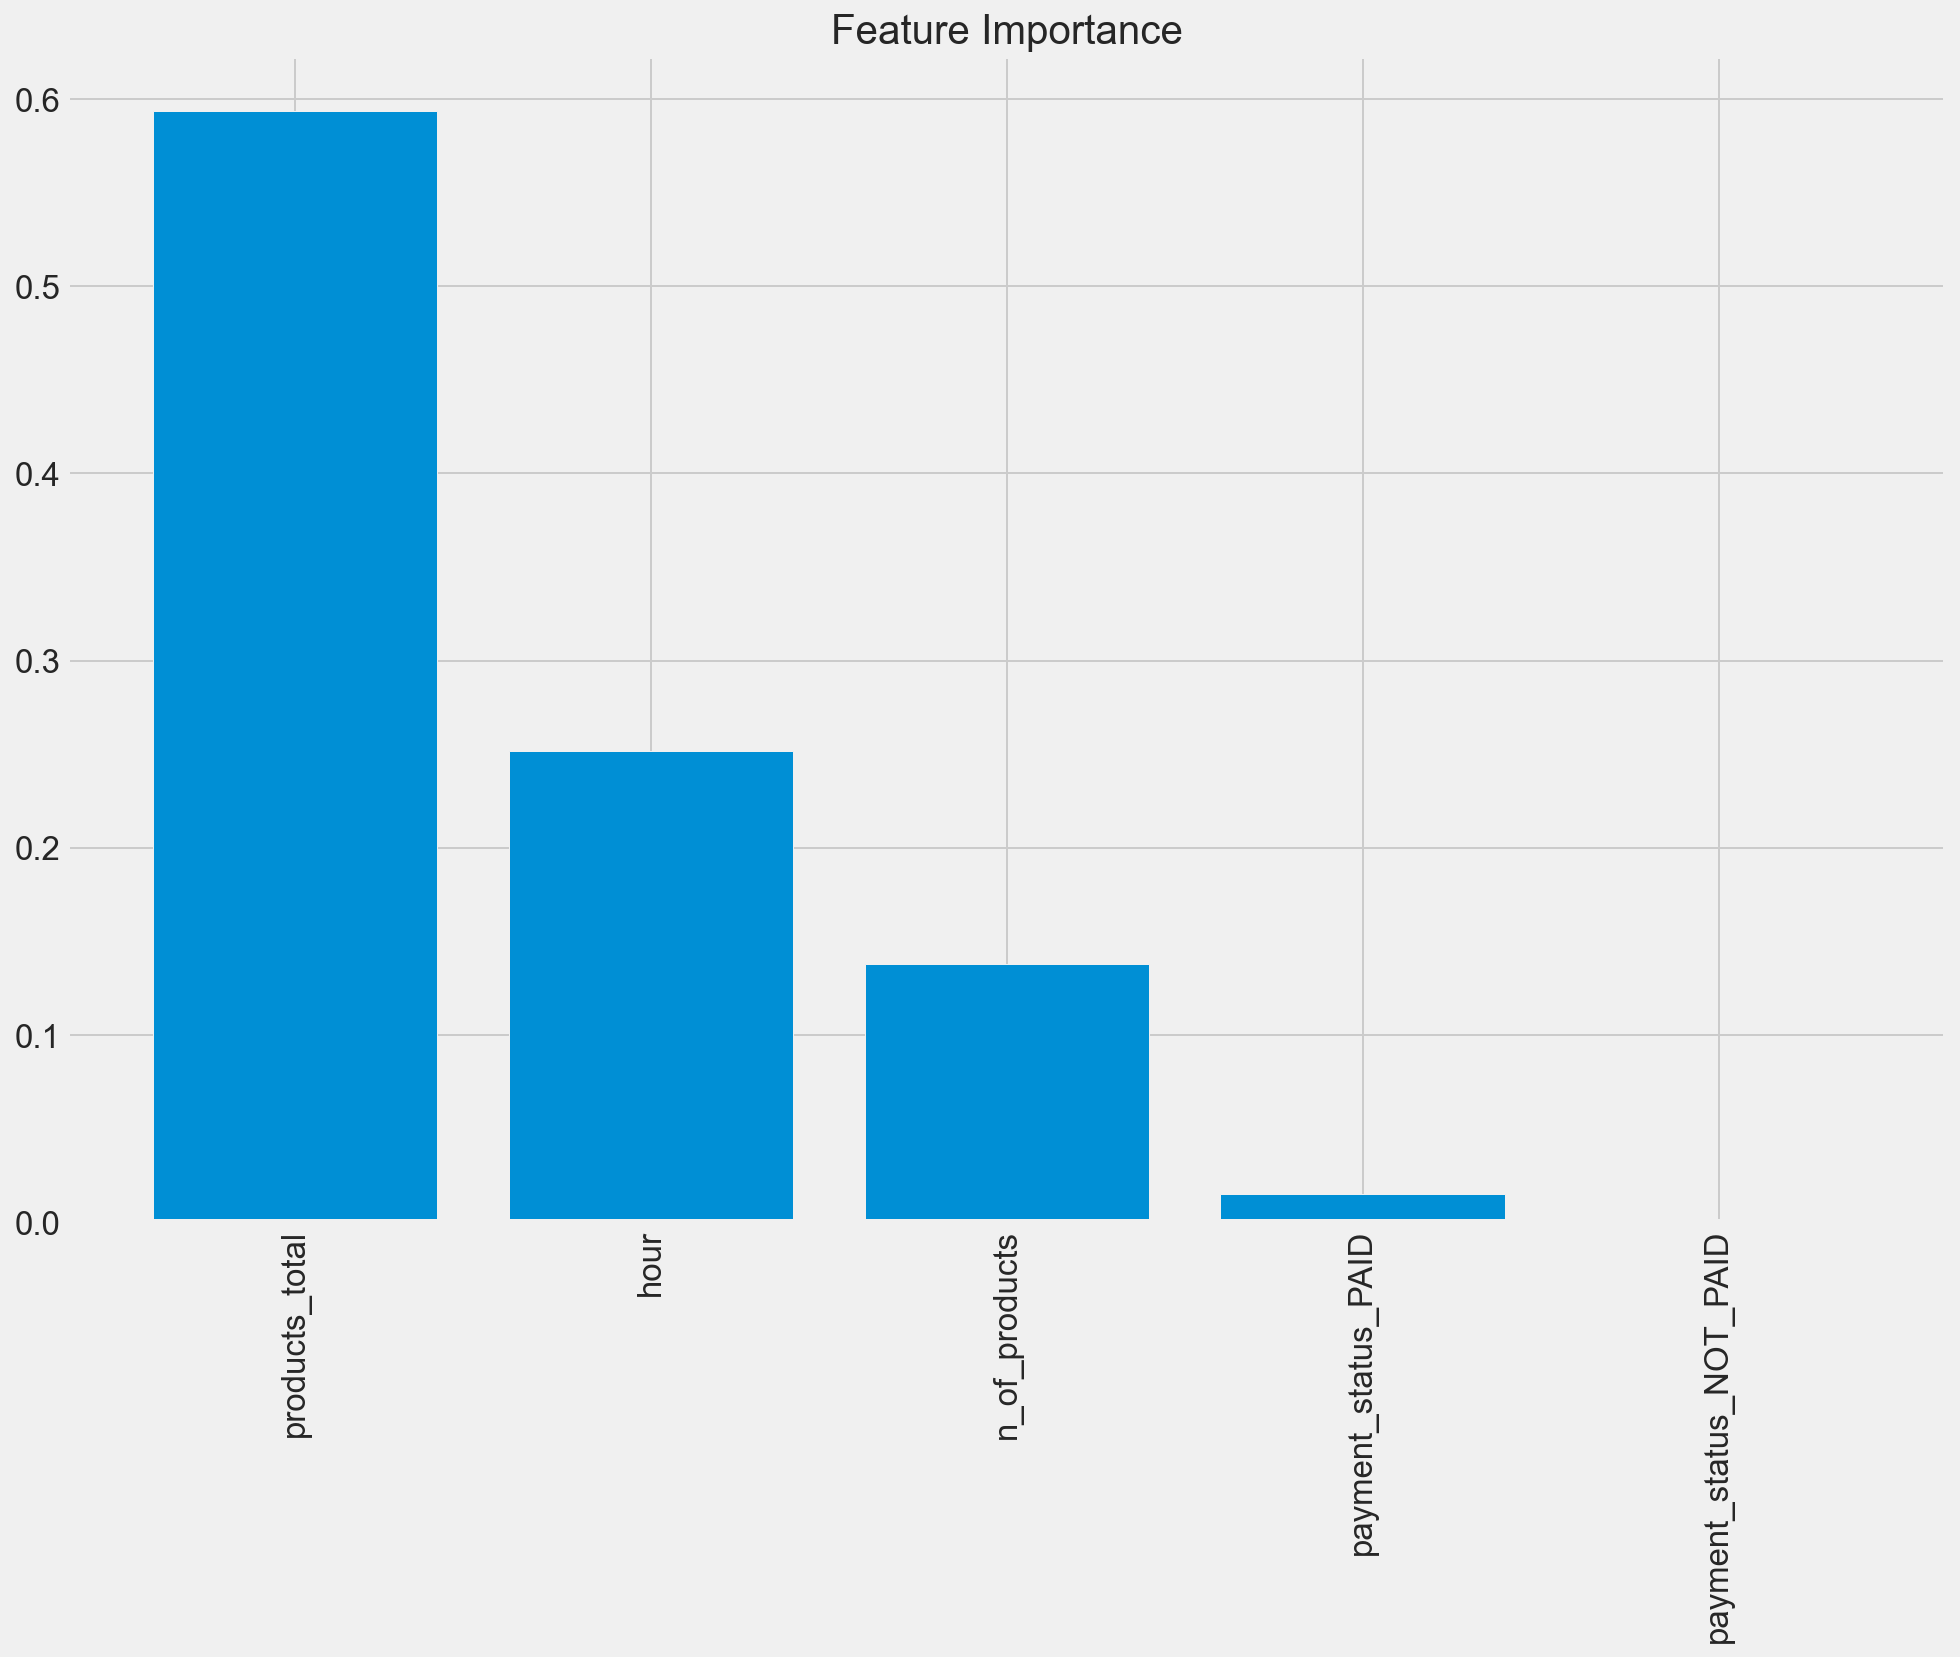

In [223]:
# Recordamos que argsort nos devuelve un vector con indices del vector original 
# tal que este quede reordenado de mayor a menor. 
# https://numpy.org/doc/stable/reference/generated/numpy.argsort.html

# creamos una variable que tenga los indices indicando los valores de mayor a menor
indices = np.argsort(importances_os)[::-1]

# con dicha variable realizamos fancy indexing de manera de ordenar los labels del eje x.
names = X_model.columns[indices]

# Creamos el plot
plt.figure(figsize=(15,10))

# Creamos plot title
plt.title("Feature Importance")

# Agregamos las barras
plt.bar(range(X_model.shape[1]), importances_os[indices])

# Agregamos los feature names 
plt.xticks(range(X_model.shape[1]), names, rotation=90)

# Show plot
plt.show()

In [224]:
y_pred_gb_os = grid_gb_os.best_estimator_.predict(X_test)

In [225]:
conf_mat = confusion_matrix(y_test, y_pred_gb_os)
conf_mat

array([[10669,  3880],
       [ 1111,   639]], dtype=int64)

Al equilibrar la cantidad de cancelados en nuestra data de entrenamiento, vemos como nuestro modelo aprende mejor las características que hacen a un pedido cancelado, pudiendo predecir correctamente 639 casos (contra 2 del modelo sin oversampling)

Veremos si podemos mejorar un poco más la performance, mediante la estandarización de features numéricas, a fin no distorsionar el modelo con las diferencias de escala.


## Standard Scaler

In [226]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()  
    
X_train_sc=scaler.fit_transform(X_train_os) # standarizing data    
X_test_sc=scaler.transform(X_test)

In [227]:
gb_os_sc = GradientBoostingClassifier()
model_performance(gb_os_sc, "GradientBoostingClassifier", X_train_sc, y_train_os, cv)

Performance of GradientBoostingClassifier:	0.58 ± 0.003


In [228]:
params_gb_sc_os = {'n_estimators':[500, 1000] , 
             'learning_rate':[0.001, 0.001, 0.1],
            'max_depth' : [1, 2, 3, 4]}

grid_gb_sc_os = GridSearchCV(gb_os_sc, param_grid=params_gb_sc_os, cv=cv, verbose=1, n_jobs=3)

In [229]:
grid_gb_sc_os.fit(X_train_sc, y_train_os)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:  8.1min
[Parallel(n_jobs=3)]: Done 120 out of 120 | elapsed: 22.5min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=41, shuffle=True),
             estimator=GradientBoostingClassifier(), n_jobs=3,
             param_grid={'learning_rate': [0.001, 0.001, 0.1],
                         'max_depth': [1, 2, 3, 4],
                         'n_estimators': [500, 1000]},
             verbose=1)

In [230]:
model_performance(grid_gb_sc_os.best_estimator_, "GradientBoostingClassifier", X_train_sc, y_train_os, cv)

Performance of GradientBoostingClassifier:	0.717 ± 0.003


<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

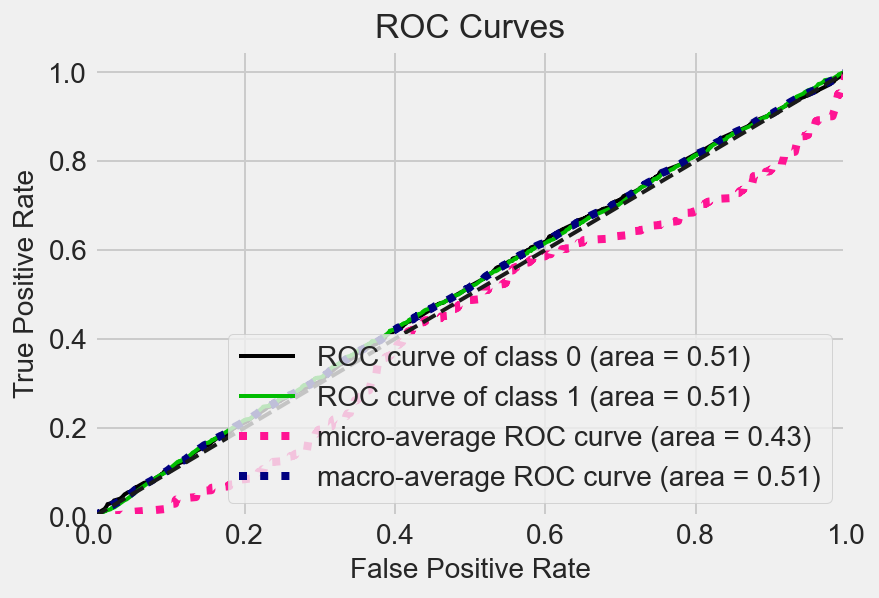

In [231]:
plot_roc(y_test,grid_gb_sc_os.predict_proba(X_test))

In [232]:
model_sc = grid_gb_sc_os.best_estimator_
model_sc

GradientBoostingClassifier(max_depth=4, n_estimators=1000)

In [233]:
importances_sc = model_sc.feature_importances_
importances_sc

array([0.1376015 , 0.59356122, 0.25193815, 0.00179803, 0.0151011 ])

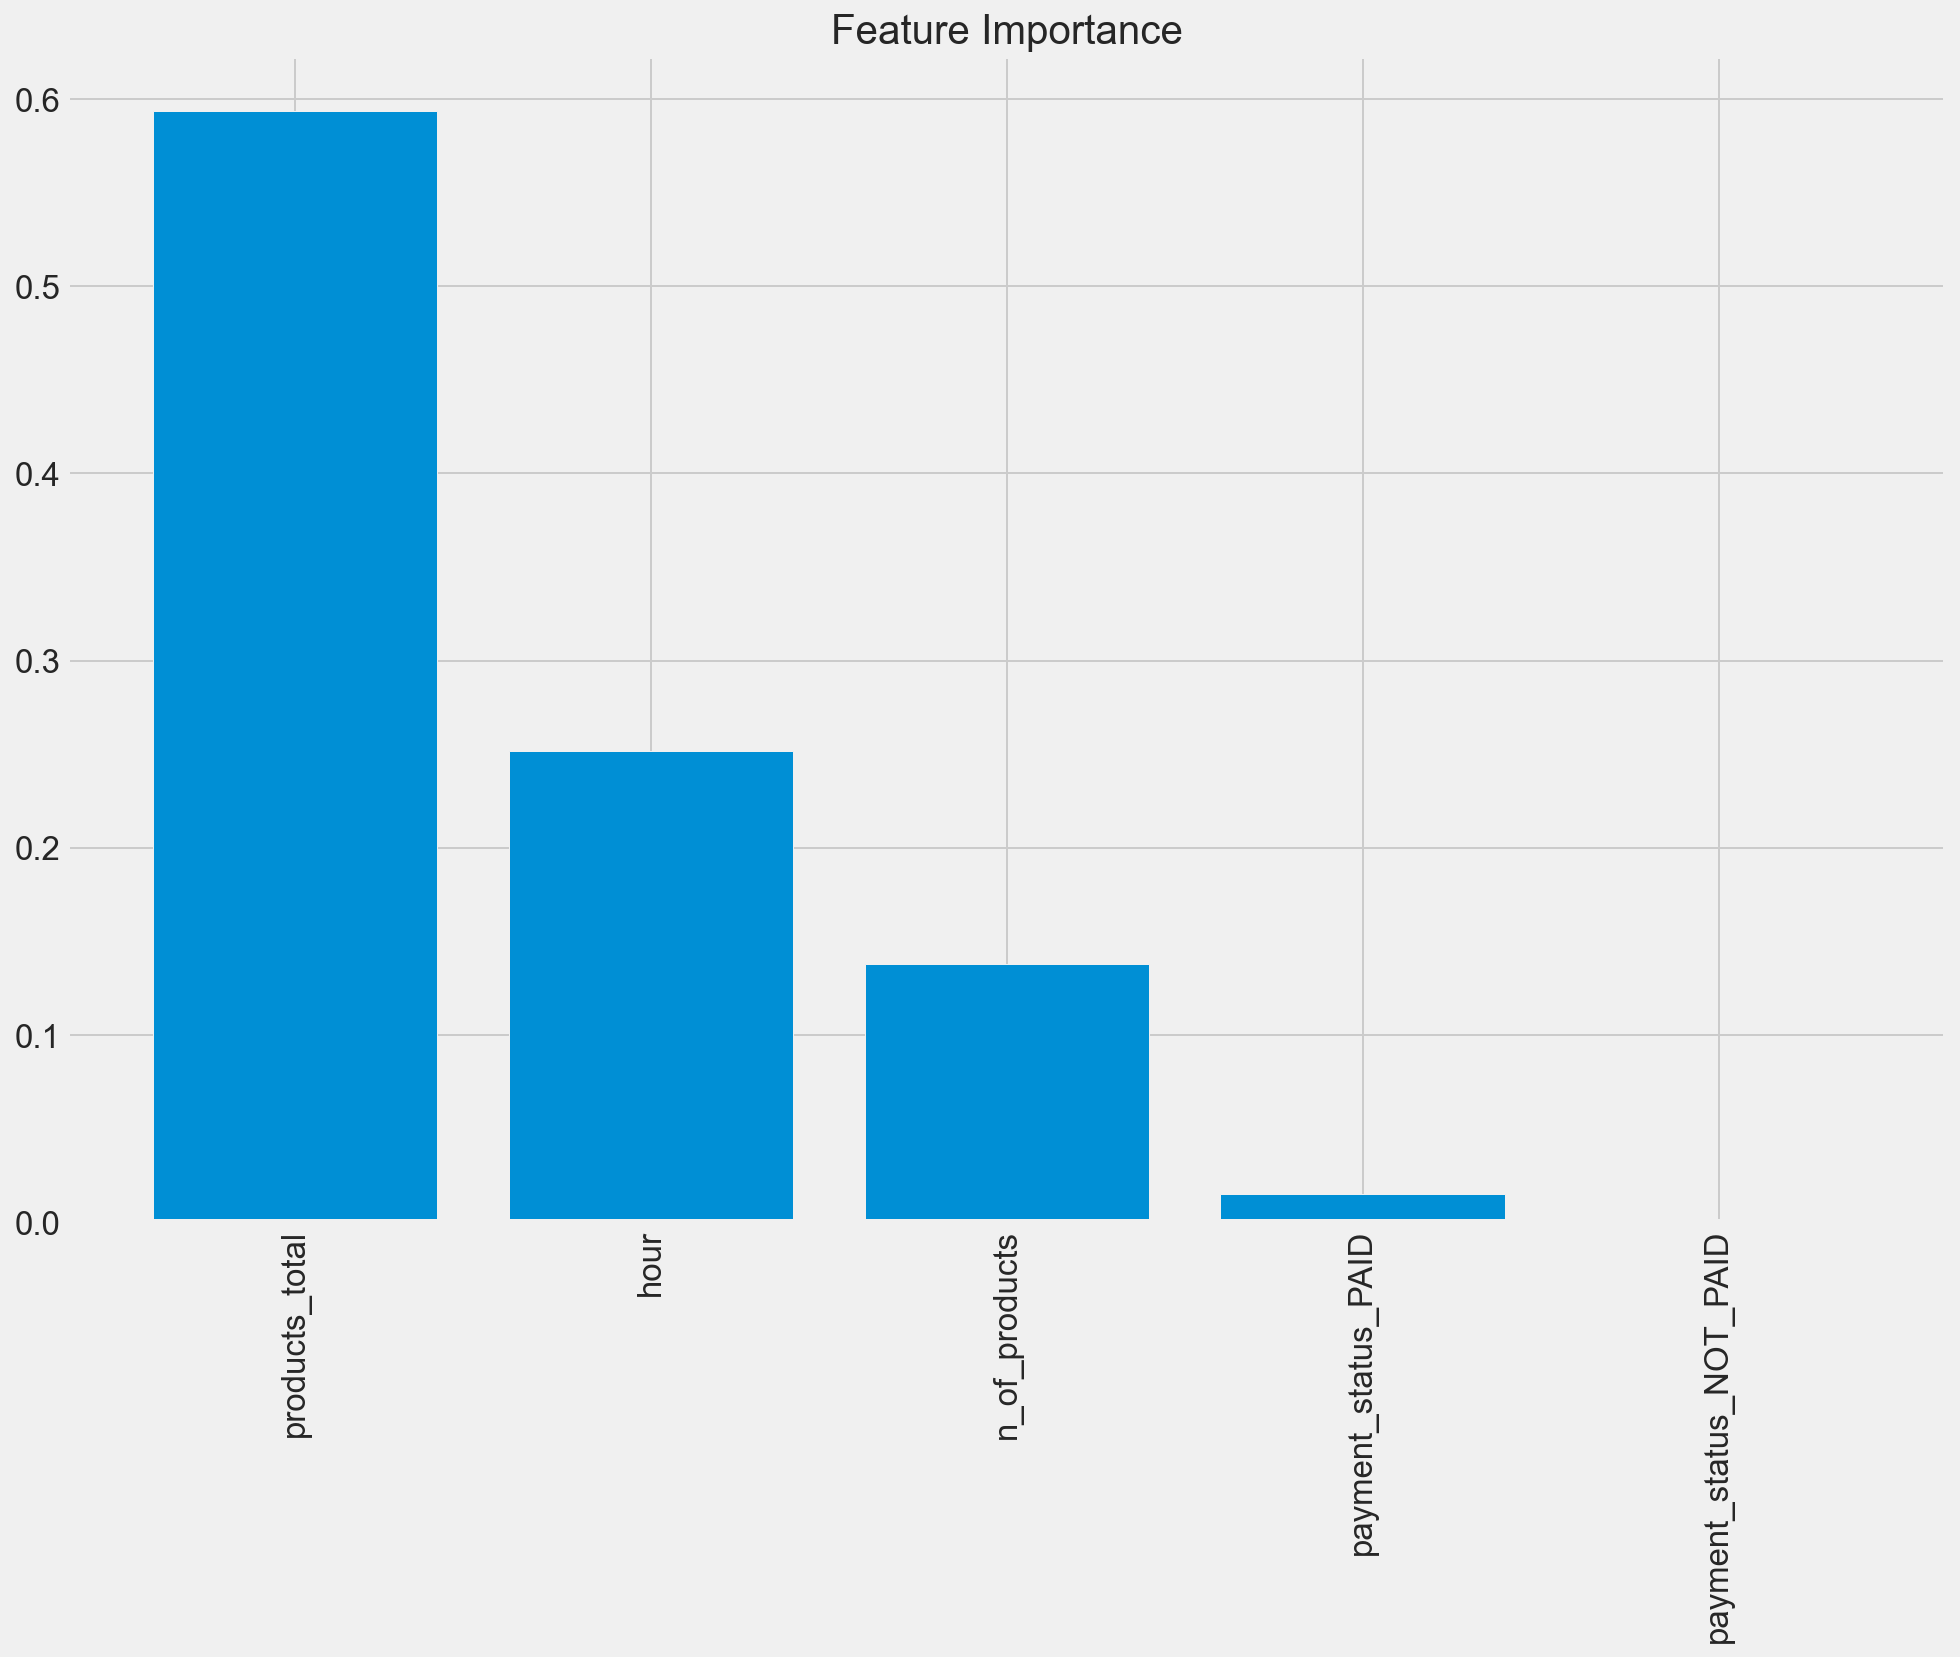

In [234]:
# Recordamos que argsort nos devuelve un vector con indices del vector original 
# tal que este quede reordenado de mayor a menor. 
# https://numpy.org/doc/stable/reference/generated/numpy.argsort.html

# creamos una variable que tenga los indices indicando los valores de mayor a menor
indices = np.argsort(importances_os)[::-1]

# con dicha variable realizamos fancy indexing de manera de ordenar los labels del eje x.
names = X_model.columns[indices]

# Creamos el plot
plt.figure(figsize=(15,10))

# Creamos plot title
plt.title("Feature Importance")

# Agregamos las barras
plt.bar(range(X_model.shape[1]), importances_os[indices])

# Agregamos los feature names 
plt.xticks(range(X_model.shape[1]), names, rotation=90)

# Show plot
plt.show()

In [235]:
y_pred_gb_sc = grid_gb_sc_os.best_estimator_.predict(X_test)

In [236]:
conf_mat = confusion_matrix(y_test, y_pred_gb_sc)
conf_mat

array([[7033, 7516],
       [ 816,  934]], dtype=int64)

Si bien aumentó la cantidad de predicciones de "pedidos cancelados", vemos que también aumentó el error y disminuyó la cantidad de predicciones correctas para el target 0. Incluso el area bajo las curvas ROC disminuyó.
Es por eso que nos quedaremos con el modelo oversampleado pero sin estandarizar, que mantiene un mejor equilibrio entre aciertos y error.

----------------------------------------
## Dataset de testeo y prediccion de nuevas features
-------------------------------------------

In [237]:
df_uknown = pd.read_csv('test_X.csv')

In [238]:
df_uknown.head(2)

,order_id,local_time,country_code,store_address,final_status,payment_status,n_of_products,products_total,purchase_total_price
0,33557880,23:59:59,AR,14200,DeliveredStatus,PAID,1,4.54,8.64
1,33512615,23:58:32,TR,28725,DeliveredStatus,PAID,1,3.76,3.76


Como podemos observar, quizás por un error en el dataset, tenemos los valores de final_status que en teoría son nuestro target.

Vamos a quitar dicha feature y hacer de cuenta que nunca estuvo en nuestro dataset.

In [239]:
df_uknown.isnull().sum() ##Verificamos la existencia de valores nulos

order_id                0
local_time              0
country_code            0
store_address           0
final_status            0
payment_status          0
n_of_products           0
products_total          0
purchase_total_price    0
dtype: int64

In [240]:
df_uknown['hour'] = df_uknown.local_time.apply(lambda x: x[0:2]).astype('int64') # Extraemos la hora

In [241]:
df_uknown = df_uknown.drop(['order_id','local_time','store_address','purchase_total_price', 
                            'country_code', 'final_status'], axis=1)

In [242]:
df_uknown.columns

Index(['payment_status', 'n_of_products', 'products_total', 'hour'], dtype='object')

In [243]:
df_uknown.isnull().sum()

payment_status    0
n_of_products     0
products_total    0
hour              0
dtype: int64

In [244]:
df_uknown = pd.get_dummies(df_uknown, drop_first=False) ## vamos a eliminar manualmente la misma columna que en train

In [245]:
df_uknown = df_uknown.drop(['payment_status_DELAYED'], axis=1)

In [246]:
y_test_pred=model_os.predict(df_uknown)

In [247]:
predictions = pd.DataFrame(y_test_pred)
predictions.columns = ['Y_Pred']
predictions.to_csv('predictions_delivery.csv', index=False)

![](https://media.istockphoto.com/vectors/the-end-movie-screen-background-vintage-cinema-or-film-poster-retro-vector-id1191605696?k=20&m=1191605696&s=612x612&w=0&h=PtNI14N0vwG83_eShXhkPKo3YUIJYnwOlp7AQSfUzOE=)